# Positioner ID Tests
Paul Martini, Duan Yutong

1.  Experiments with identifying positioners in FVC .pos files
2.  Examining pairs of .pos files and seeing which ones do not move

In [2]:
from astropy.io import ascii
import pandas as pd
import sys
import os
import numpy as np
from scipy.optimize import minimize

In [3]:
# path definitions for dyt
petal_dir = r'K:\Google Drive\DESI\repository\repository_svn\focalplane\plate_control\trunk\petal'
sys.path.append(petal_dir)
os.environ['POSITIONER_LOGS_PATH'] = r'K:\Google Drive\DESI\repository\repository_svn\focalplane\positioner_logs'
os.environ['FP_SETTINGS_PATH'] = r'K:\Google Drive\DESI\repository\repository_svn\focalplane\fp_settings'

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
from petaltransforms import PetalTransforms

### Email from Parker on 8 October 2019

Hello All,
I ran a functional test on all the petals, moving all positioners by -30 deg in PHI followed by +60 deg in THETA. I made the moves using the Petal Control Panel. Whenever a move is made using the Petal Controller, you can only do it one CAN bus at a time. It also brings all positioners out of stop mode when moving the positioners on a given CAN Bus. Therefore, we moved all the positioners for a given CAN Bus every 1 minute. This seemed to keep the positioners at a good temperature. I can send that thermal data later if needed.

Below I capture the FVC image numbers to be used to evaluate whether or not the positioners for a given petal did move. I believe Duan is working on Petal 3 right now but we will have to evaluate all petals. Paul has volunteered to start looking at the other petals.

Each fvc image also has an associated .pos file with the centroids. Each image taken was 1 second. The images can be found at msdos@desi-fvc.kpno.noao.edu:/data/images/fvc

Important Notes:
 * PC00 - One fewer positioner on CAN11 than previously expected.
 * PC02 - Non responsive CAN ID 5675 on CAN 13 (according to doslogs). Can bus seems to be ok
 * PC03 - Non responsive CAN ID 5300 on CAN 15. CAB Bus intermittent behavior. Might need to shut off CAN 15. Still looking into this.
 * PC04 - On fewer positioner  on CAN 16 than previously expected
 * PC06 - One fewer positioner found on CAN 15 and 16 as previously expected
 * PC05 - One more positioner on CAN 17 than expected. Weird!

- PC,Initial,PHI,THETA
- PC00, fvc.20191003232306.fits, fvc.20191003233356.fits, fvc.20191003234547.fits
- PC01, fvc.20191003234904.fits, fvc.20191004000051.fits, fvc.20191004001051.fits
- PC02, fvc.20191004170751.fits, fvc.20191004190200.fits, fvc.20191004191322.fits
- PC03, fvc.20191003213313.fits, fvc.20191003214640.fits, fvc.20191003222441.fits
- PC04, fvc.20191003222441.fits, fvc.20191004190200.fits, fvc.20191007152624.fits
- PC05, fvc.20191007152624.fits, fvc.20191007153833.fits, fvc.20191007162144.fits
- PC06, fvc.20191007162144.fits, fvc.20191007172910.fits, fvc.20191007180412.fits
- PC07, fvc.20191007180412.fits, fvc.20191007183104.fits, fvc.20191007184307.fits
- PC08, fvc.20191007184307.fits, fvc.20191007185532.fits, fvc.20191007190739.fits
- PC09, fvc.20191007190739.fits, fvc.20191007192116.fits, fvc.20191007193250.fits

In [5]:
PC00 = ['fvc.20191003232306.pos', 'fvc.20191003233356.pos', 'fvc.20191003234547.pos']
PC01 = ['fvc.20191003234904.pos', 'fvc.20191004000051.pos', 'fvc.20191004001051.pos']
PC02 = ['fvc.20191004170751.pos', 'fvc.20191004190200.pos', 'fvc.20191004191322.pos']
PC03 = ['fvc.20191003213313.pos', 'fvc.20191003214640.pos', 'fvc.20191003222441.pos']
PC04 = ['fvc.20191003222441.pos', 'fvc.20191004190200.pos', 'fvc.20191007152624.pos']
PC05 = ['fvc.20191007152624.pos', 'fvc.20191007153833.pos', 'fvc.20191007162144.pos']
PC06 = ['fvc.20191007162144.pos', 'fvc.20191007172910.pos', 'fvc.20191007180412.pos']
PC07 = ['fvc.20191007180412.pos', 'fvc.20191007183104.pos', 'fvc.20191007184307.pos']
PC08 = ['fvc.20191007184307.pos', 'fvc.20191007185532.pos', 'fvc.20191007190739.pos']
PC09 = ['fvc.20191007190739.pos', 'fvc.20191007192116.pos', 'fvc.20191007193250.pos']

In [6]:
petlist = [PC00, PC01, PC02, PC03, PC04, PC05, PC06, PC07, PC08, PC09]

In [7]:
def read_pos_data(petal_loc, exposure_number):
    pos_data = pd.read_csv(petlist[petal_loc][exposure_number], header=None,
                           usecols=[0, 1], names=['fvc_x', 'fvc_y'], sep=' ')
    return pos_data

### Code from Duan to map positioner and fiducial ID to focal plane coordinates

In [8]:
def postrans(x, y, params):
    '''
    Transform metrology locations to match FVC
    Rotation is zero to very good approximation
    '''
    rot = 0.
    scale = params[0]
    x0 = params[1]
    y0 = params[2]
    xp = scale*( x * np.cos(rot) - y * np.sin(rot)) + x0
    yp = scale*( x * np.sin(rot) + y * np.cos(rot)) + y0
    return xp, yp

In [9]:
pi_df = pd.read_csv(os.path.join('..', 'desi_positioner_indexes_20190919.csv'))
pi_df.columns = pi_df.columns.str.lower()
pi_df.set_index('device_id', inplace=True)

In [10]:
# load better alignment data
alignment = pd.read_csv(os.path.join('..', 'focal_plane_alignment_pm.csv')).set_index('PETAL_LOC').sort_index()
alignment['rot_proper(rad)']
# overwrite PM alignment data cuz we don't have any PM distortion correction here
# just do a visual best-fit for each petal, using the global FVC magnification and centre offsets
alignment['rot_proper(rad)'] = [-1.868, -1.242, -0.612,  0.0152 ,  0.652,
        1.271,  1.899  ,  2.527,  3.158,  3.792]
alignment['XPETAL(mm)'] = [-1,  -0.6, -2, -1.2, -1.2, -3,  -3.5,
        -2, -2 , -2.8 ]
alignment['YPETAL(mm)'] = [ -3, -3,  -2.6, -1,  -4,  -3 ,  -4,
       -4.5, -4 , -2.5]
petal_locs = range(10)
cols = ['obs_x', 'obs_y']
dtypes = [np.float32, np.float32]
data = {col: pd.Series(dtype=dt) for col, dt in zip(cols, dtypes)}
data = pi_df.join(pd.DataFrame(data=data, index=pi_df.index))
ptlXYZ_df = pd.read_csv(os.path.join('..', 'Petal_Metrology.csv'),
        usecols=['device_loc', 'X', 'Y', 'Z'],
        index_col='device_loc')
ptlXYZ_df['R'] = np.linalg.norm(ptlXYZ_df[['X', 'Y']], axis=1)
# shift nominal ptlXY artifically to match the distortion pattern seen in FVC images
for coord in ['X']:
    ptlXYZ_df[coord] = ptlXYZ_df[coord] + (
        (ptlXYZ_df['R']<150) * 0.04 * ptlXYZ_df[coord]
        + ((ptlXYZ_df['R']>150) & (ptlXYZ_df['R']<345)) * 7
        + (ptlXYZ_df['R']>345) * (2.5-0.05*(ptlXYZ_df[coord]-370)))
for petal_loc in petal_locs:
    trans = PetalTransforms(Tx=alignment.loc[petal_loc, 'XPETAL(mm)'],
                            Ty=alignment.loc[petal_loc, 'YPETAL(mm)'],
                            gamma=alignment.loc[petal_loc, 'rot_proper(rad)'])
    obsXY = trans.ptlXYZ_to_obsXY(ptlXYZ_df.iloc[:, :3].T.values)
    xy_df = pd.DataFrame(data=obsXY.T, index=ptlXYZ_df.index, columns=['obs_x', 'obs_y'])
    # use device_loc for update as some are defined but not installed
    petal_data = data[data['petal_loc'] == petal_loc].reset_index().set_index('device_loc')
    petal_data.update(xy_df)
    data.update(petal_data.reset_index().set_index('device_id'))

<IPython.core.display.Javascript object>


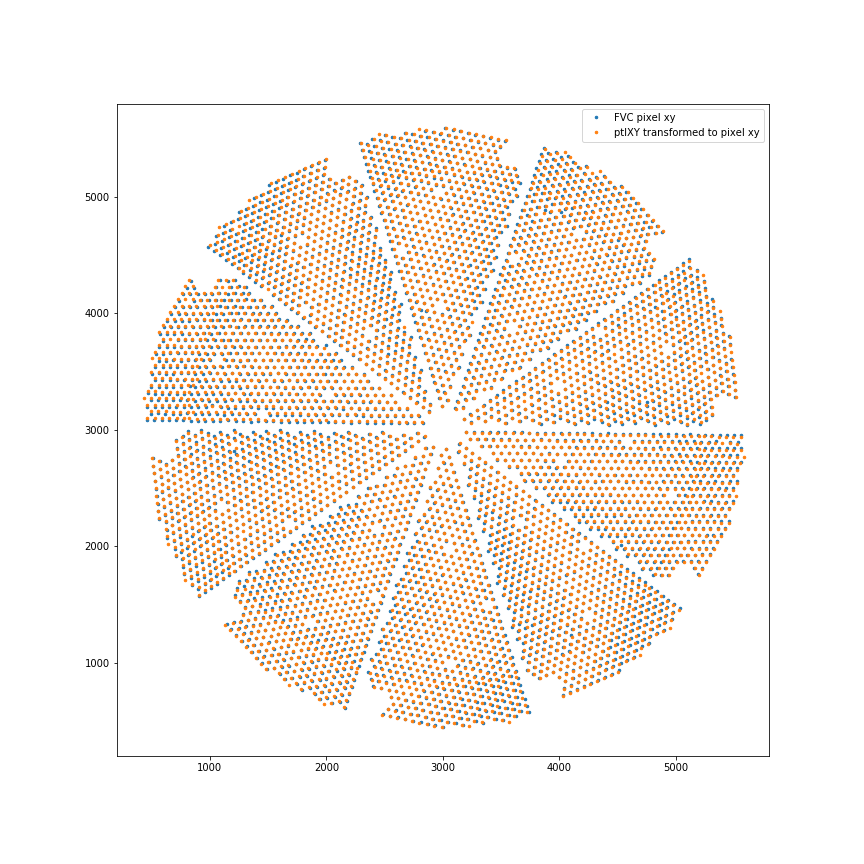

In [11]:
# Overplot FVC coordinates and transformed metrology
# (clearly it would be better to compute separate offsets for each petal)
# FVC data: (use PC00[0] as it was obtained before any moves)
posdata = ascii.read(PC00[0]) 
xfvc = posdata['col1']
yfvc = posdata['col2']
posmask = data['device_type'] == 'POS'
fidmask = ~posmask
xmet = data['obs_x'][posmask]
ymet = data['obs_y'][posmask]
params = [6.29, 3000.3600823, 3038.49451303]
xmet_fvc_out, ymet_fvc_out = postrans(-1.*xmet, ymet, params)
lim1 = 200
lim2 = 5800
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.plot(xfvc, yfvc, '.', label="FVC pixel xy", ms=5)
ax.plot(xmet_fvc_out, ymet_fvc_out, '.', label="ptlXY transformed to pixel xy", ms=5)
ax.set_xlim(lim1, lim2)
ax.set_ylim(lim1, lim2)
ax.legend()
ax.set_aspect('equal')
fig.savefig('spots.pdf')

In [13]:
# write distorted obsXY data to 'data'
obs_x_px, obs_y_px = postrans(-1*data['obs_x'], data['obs_y'], params)
data['obs_x_px'] = obs_x_px
data['obs_y_px'] = obs_y_px

<IPython.core.display.Javascript object>


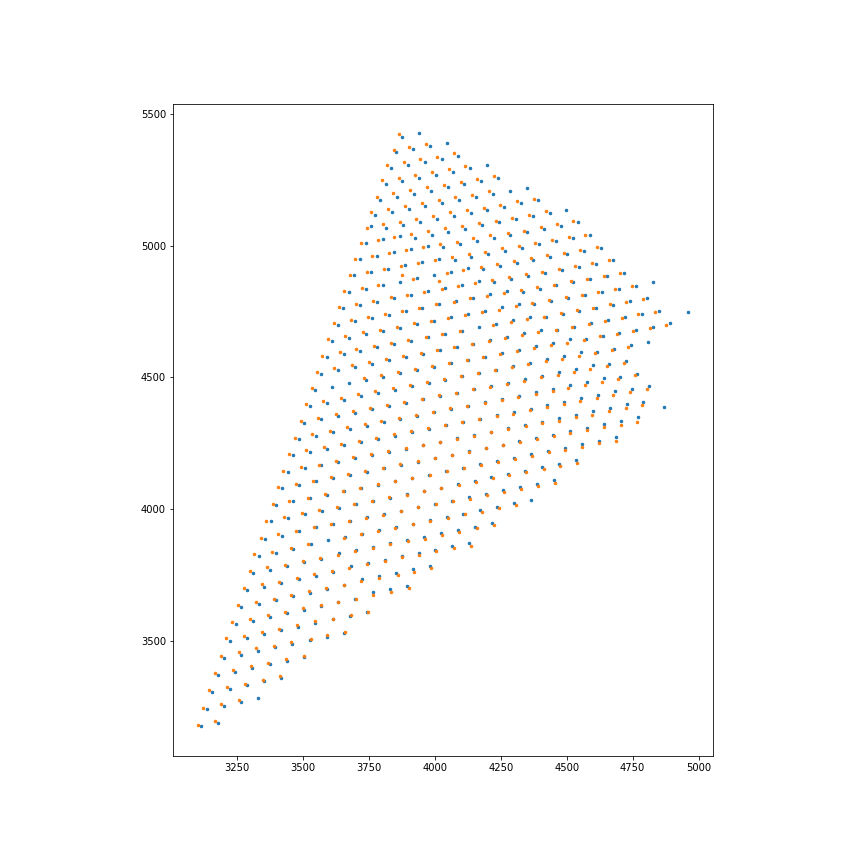

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
dp = data[data['petal_loc']==6]
ax.plot(dp['obs_x_px'], dp['obs_y_px'], '.', label="obs xy px", ms=5)
pos_data = read_pos_data(6, 0)
pet_mask = MakePetalMask(pos_data['fvc_x'].values, pos_data['fvc_y'].values, 6)
pos_data = pos_data[pet_mask]
ax.plot(pos_data['fvc_x'], pos_data['fvc_y'], '.', label="FVC pixel xy", ms=5)
ax.set_aspect('equal')

'data' contains the distorted obsXY coordinates of all devices that come from the nominal design, as well as the distorted coordinates transformed in fvc pixel space using previously found best params

In [15]:
data

device_type  petal_id  bus_id  ...       obs_y     obs_x_px     obs_y_px
device_id                                ...                                      
M00282            POS       6.0    12.0  ... -117.432274  1729.302288  2299.845510
M00283            POS       8.0    10.0  ...   79.485906  2748.739471  3538.460864
M00284            POS       6.0    12.0  ... -125.001956  1562.711059  2252.232207
M00296            POS       8.0    13.0  ...  136.916048  2087.870694  3899.696457
M00325            POS       8.0    11.0  ...   91.439744  2463.166097  3613.650501
...               ...       ...     ...  ...         ...          ...          ...
P133              FIF       5.0    13.0  ... -141.156608  2432.546183  2150.619448
P134              FIF       4.0    16.0  ... -414.109134  3052.713988   433.748062
P135              GIF       5.0    22.0  ... -221.637024  1156.207773  1644.397631
P359              GIF       3.0    22.0  ...  211.014532  1129.699382  4365.775921
P669              GIF       3.0    22.0  ...  207.134652   760.865600  4341.371475

[5143 rows x 15 columns]

<IPython.core.display.Javascript object>


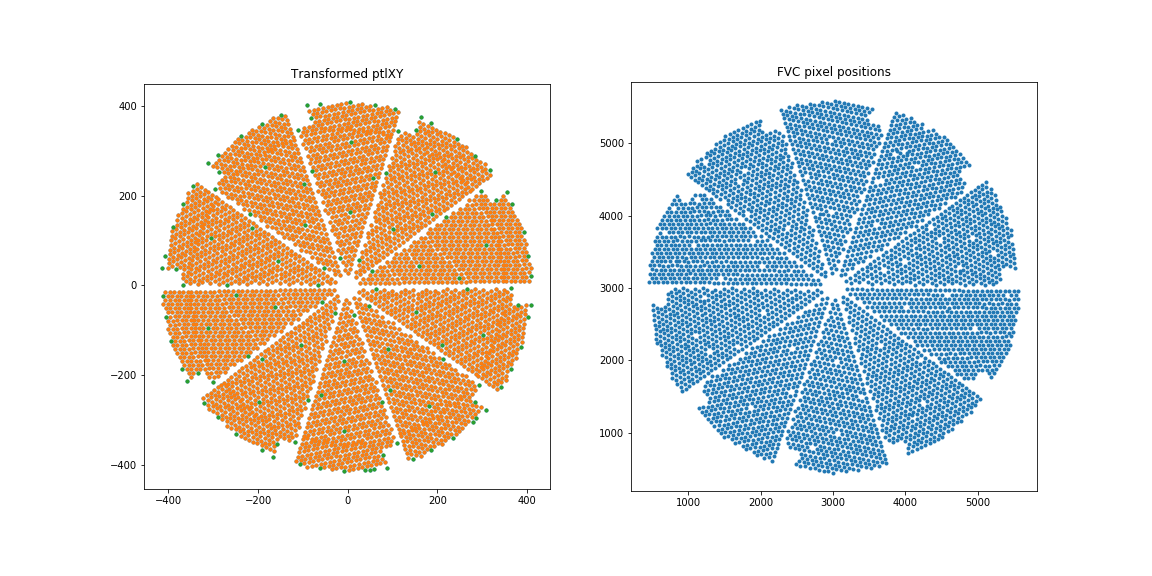

In [16]:
fig, axarr = plt.subplots(1, 2, figsize=(16,8))
axarr[0].plot(data['obs_x'], data['obs_y'], '.')
axarr[0].plot(data['obs_x'][posmask], data['obs_y'][posmask], '.')
axarr[0].plot(data['obs_x'][fidmask], data['obs_y'][fidmask], '.')
axarr[0].set_title("Transformed ptlXY")
posdata = ascii.read(PC00[0])
axarr[1].plot(posdata['col1'], posdata['col2'], '.')
axarr[1].set_title("FVC pixel positions")
axarr[0].set_aspect('equal')
axarr[1].set_aspect('equal')

### Notes:
1. Based on above need to flip y axis to match orientation. Should figure out why. (FVC has always had a y-flip including in the lab)
2. Bottom petal is always petal_loc = 0, PC00. In CS5, count counter-clockwise from 0 to 9, whereas in FVC pixel space, count clockwise from 0 to 9.

### Routines to separate FVC measurements into petals

In [17]:
# Define a triangle that encloses each petal in FVC pixels
def getpostriangle(petal_loc):
    xc, yc = 3020.3600823, 3015
    theta0 = 180.4
    theta1 = (36*petal_loc - 18. + theta0)*np.pi/180.
    theta2 = (36*petal_loc + 18. + theta0)*np.pi/180.
    x1 = 3000*np.sin(theta1) + xc
    y1 = 3000*np.cos(theta1) + yc
    x2 = 3000*np.sin(theta2) + xc
    y2 = 3000*np.cos(theta2) + yc
    return [x1, x2, xc, x1], [y1, y2, yc, y1]

<IPython.core.display.Javascript object>


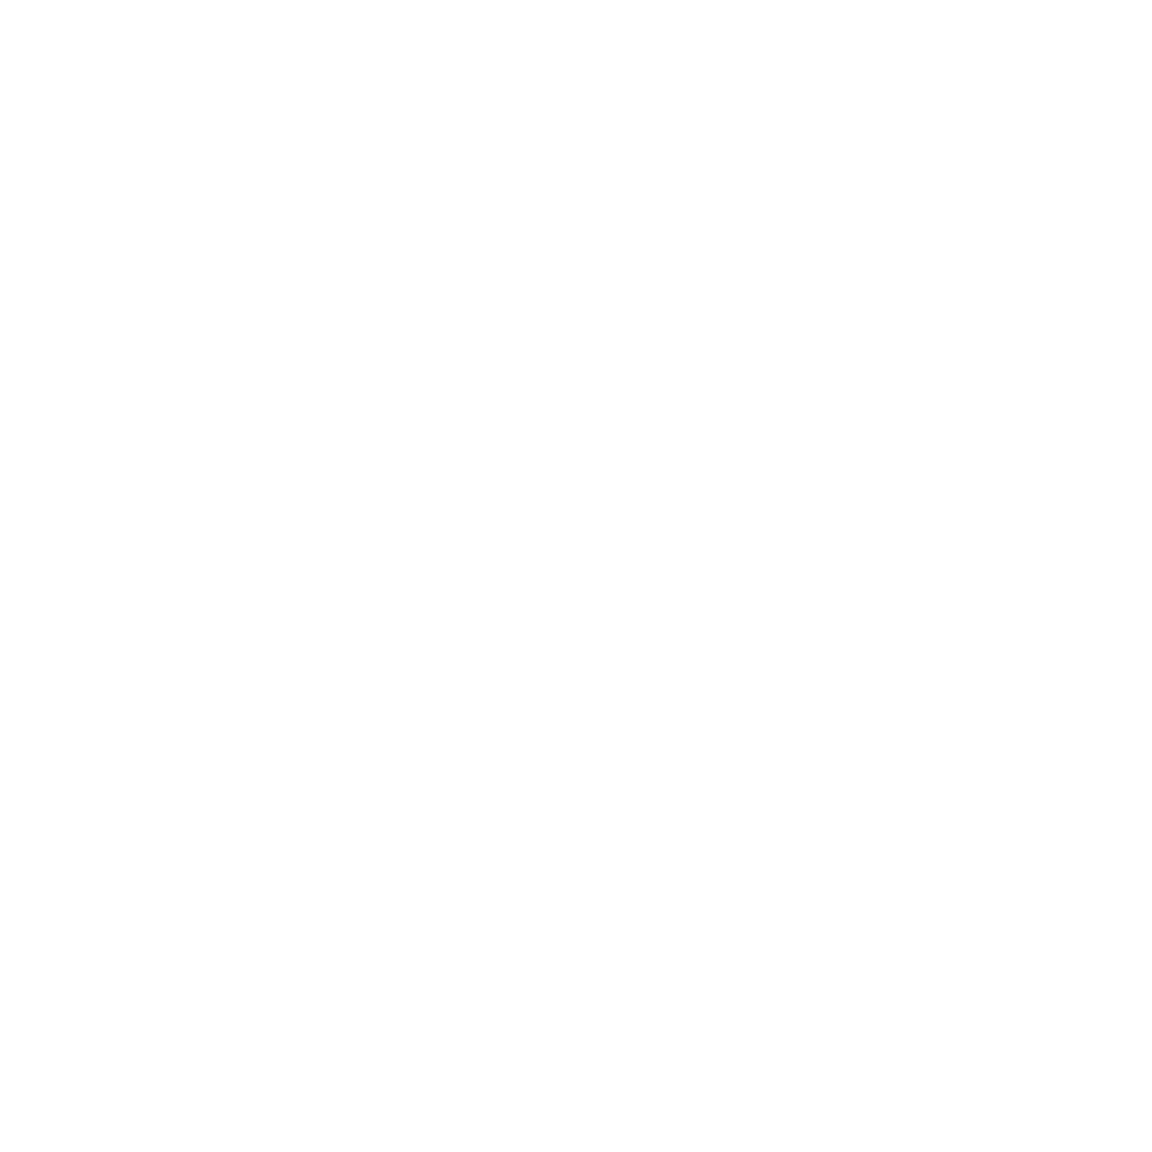

<IPython.core.display.Javascript object>


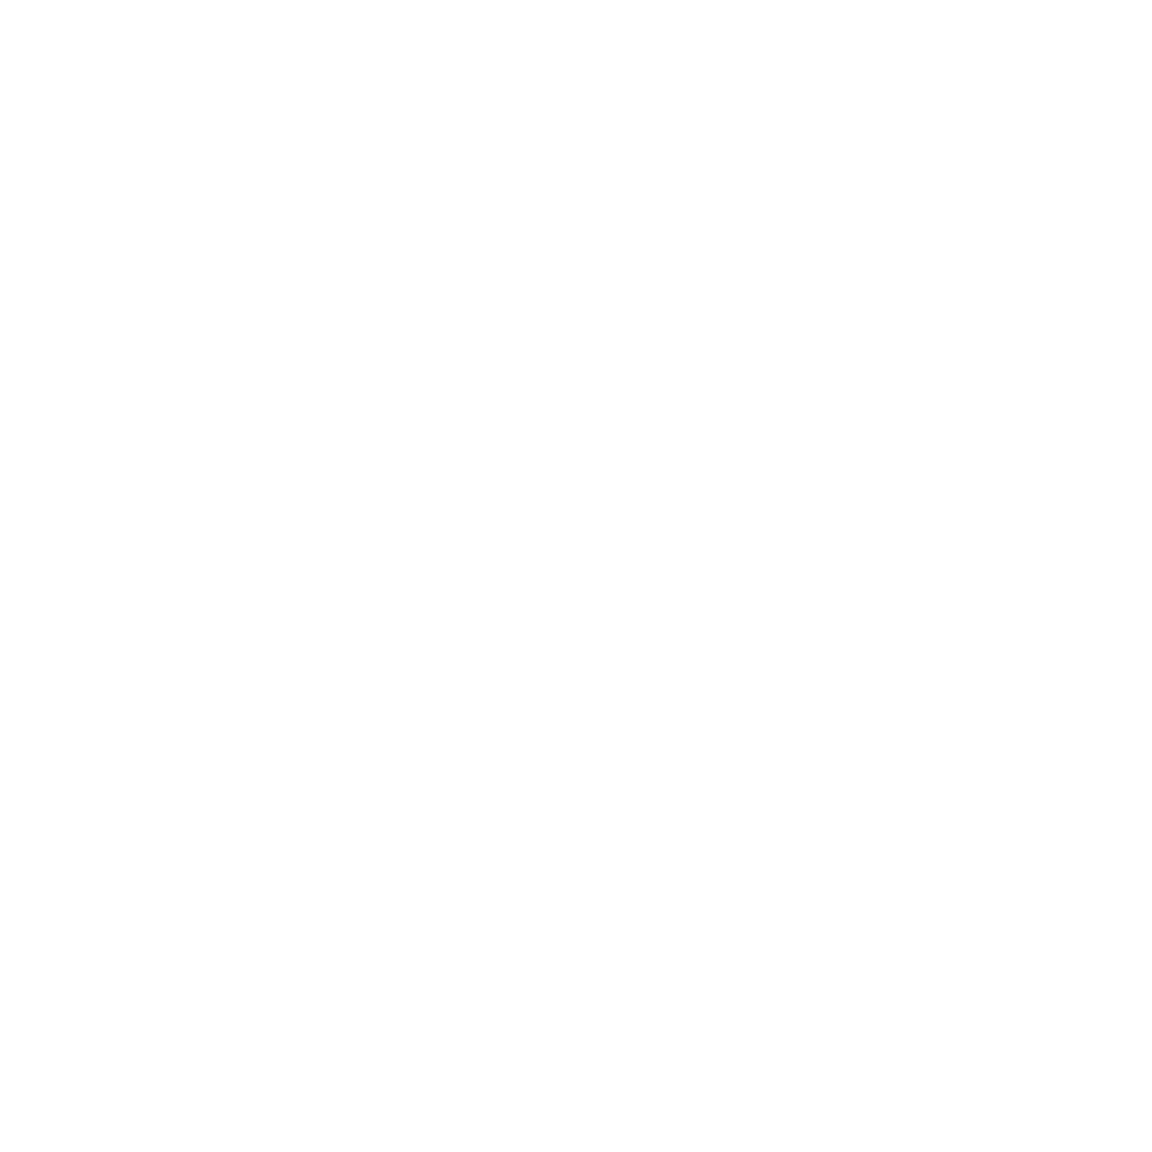

<IPython.core.display.Javascript object>


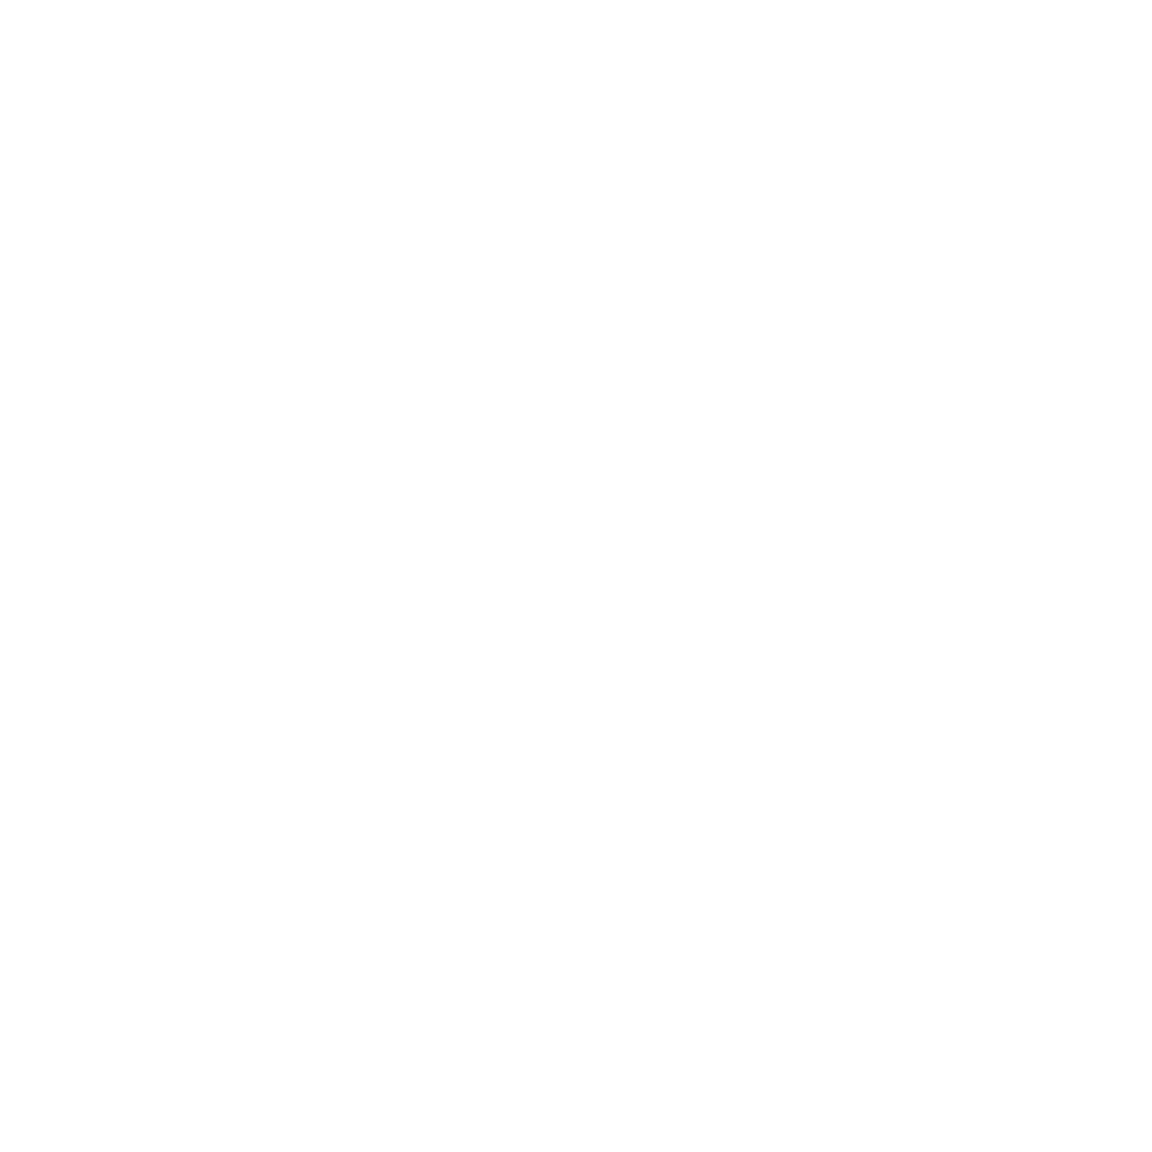

<IPython.core.display.Javascript object>


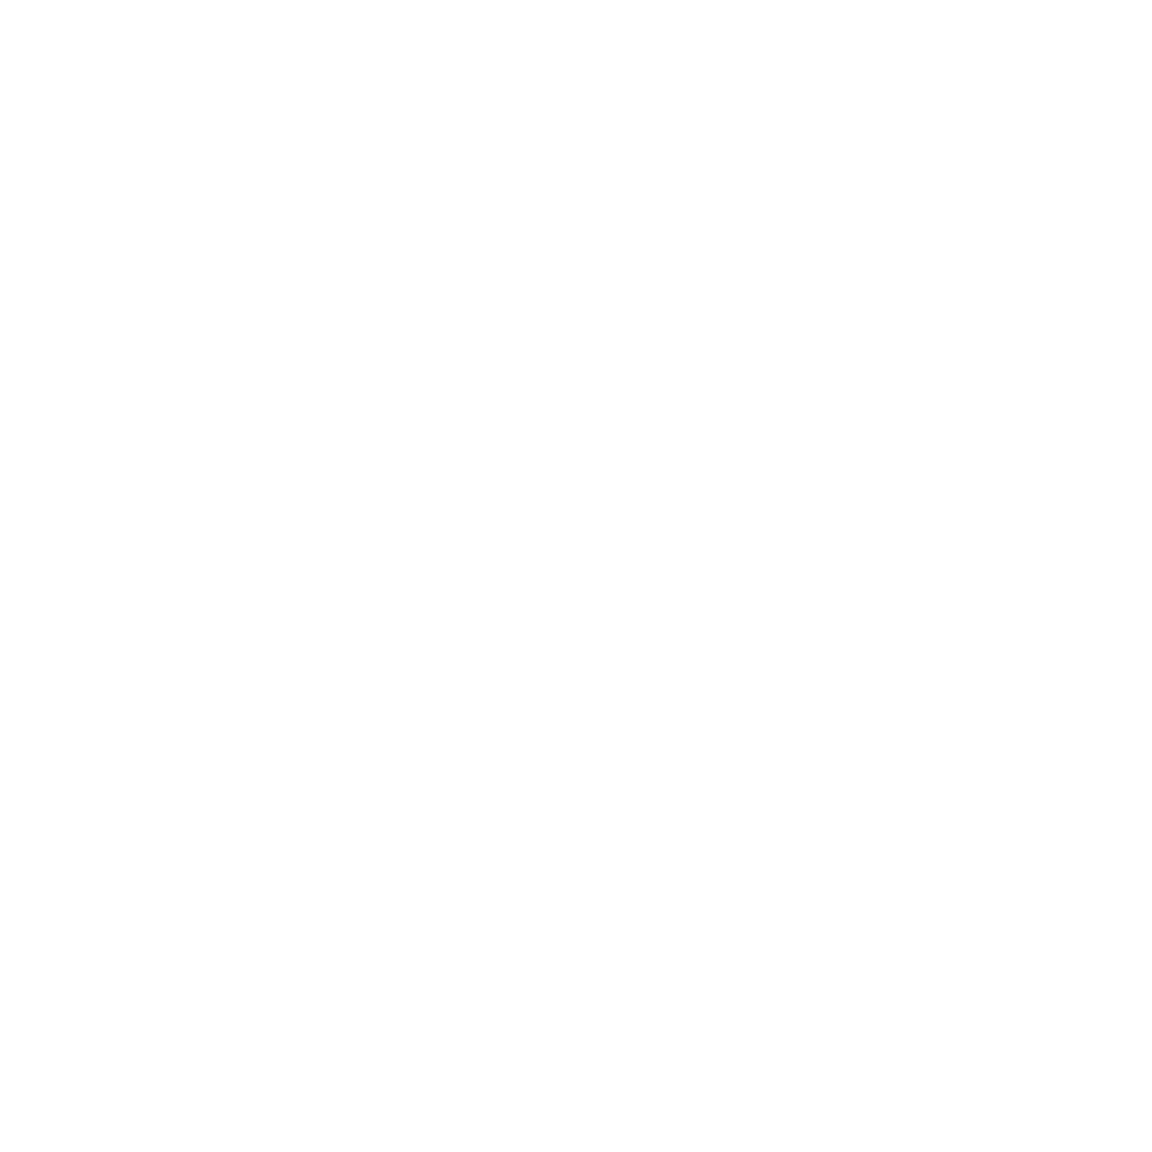

<IPython.core.display.Javascript object>


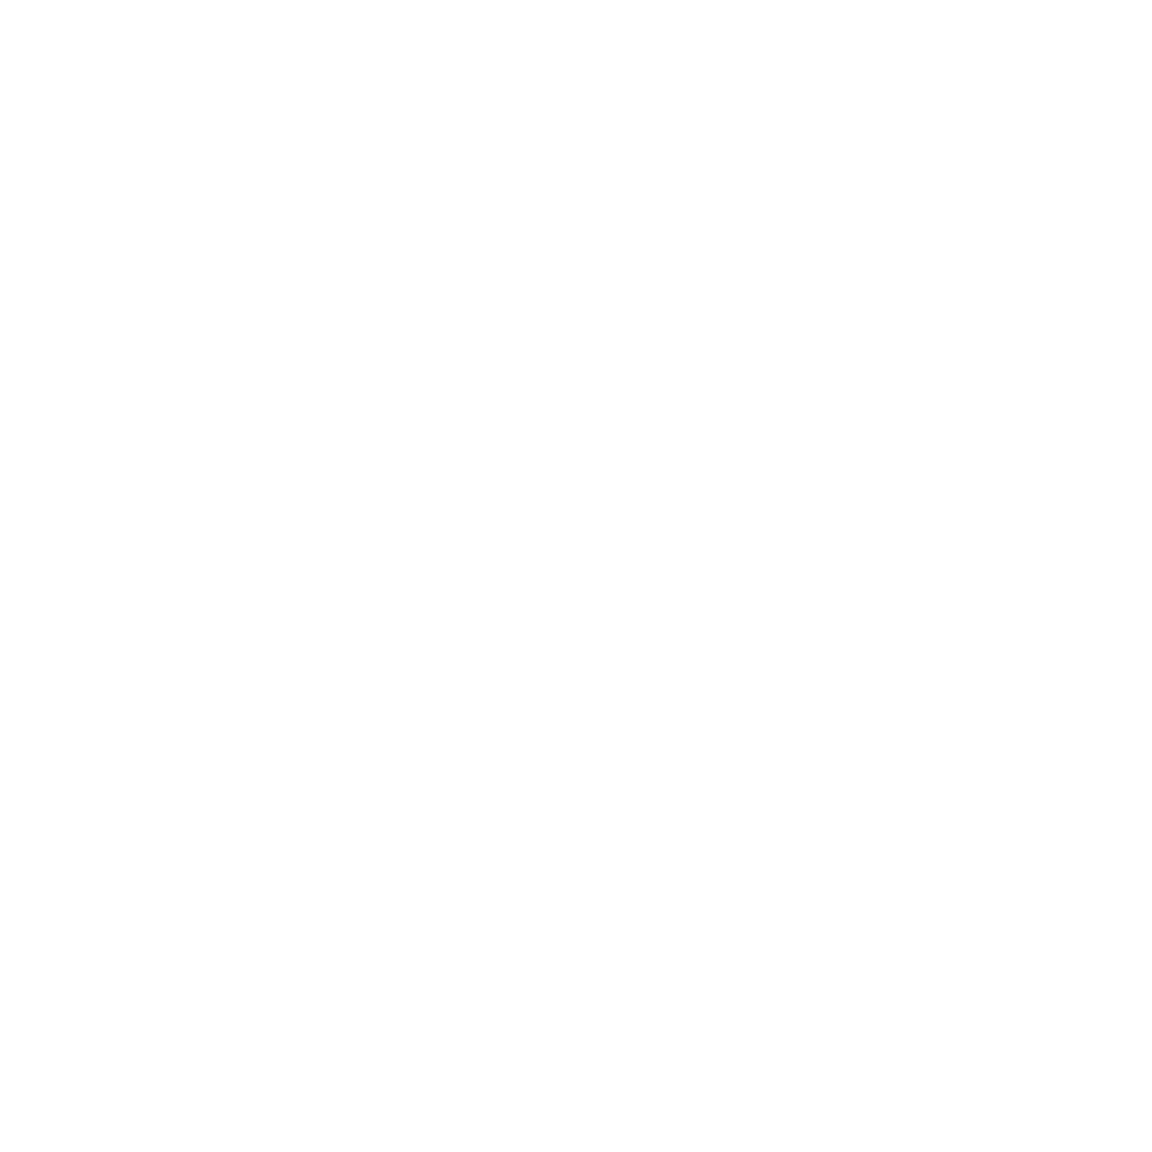

<IPython.core.display.Javascript object>


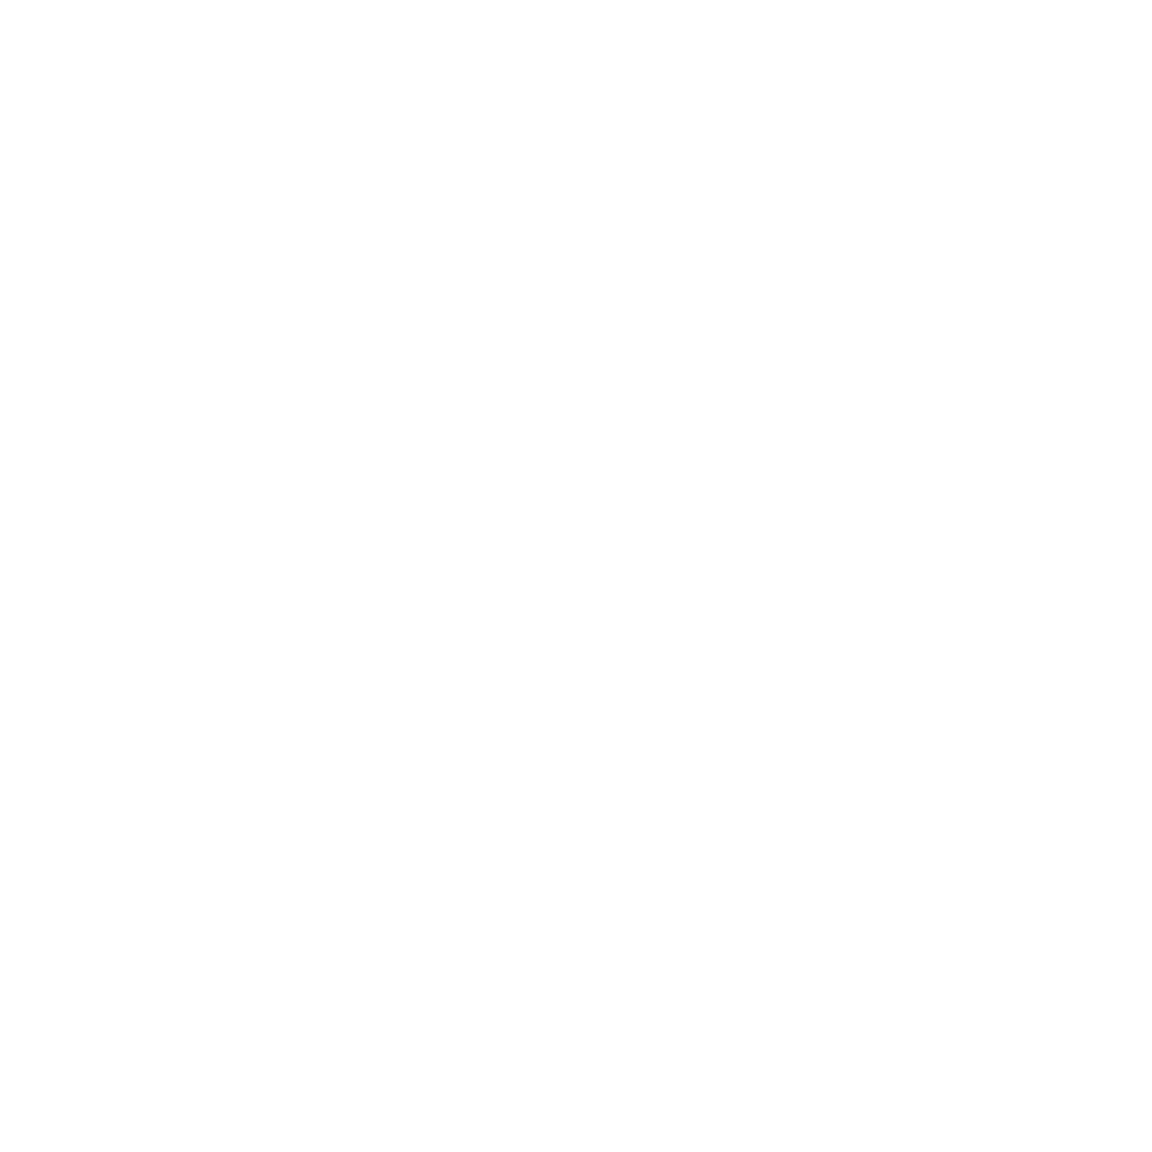

<IPython.core.display.Javascript object>


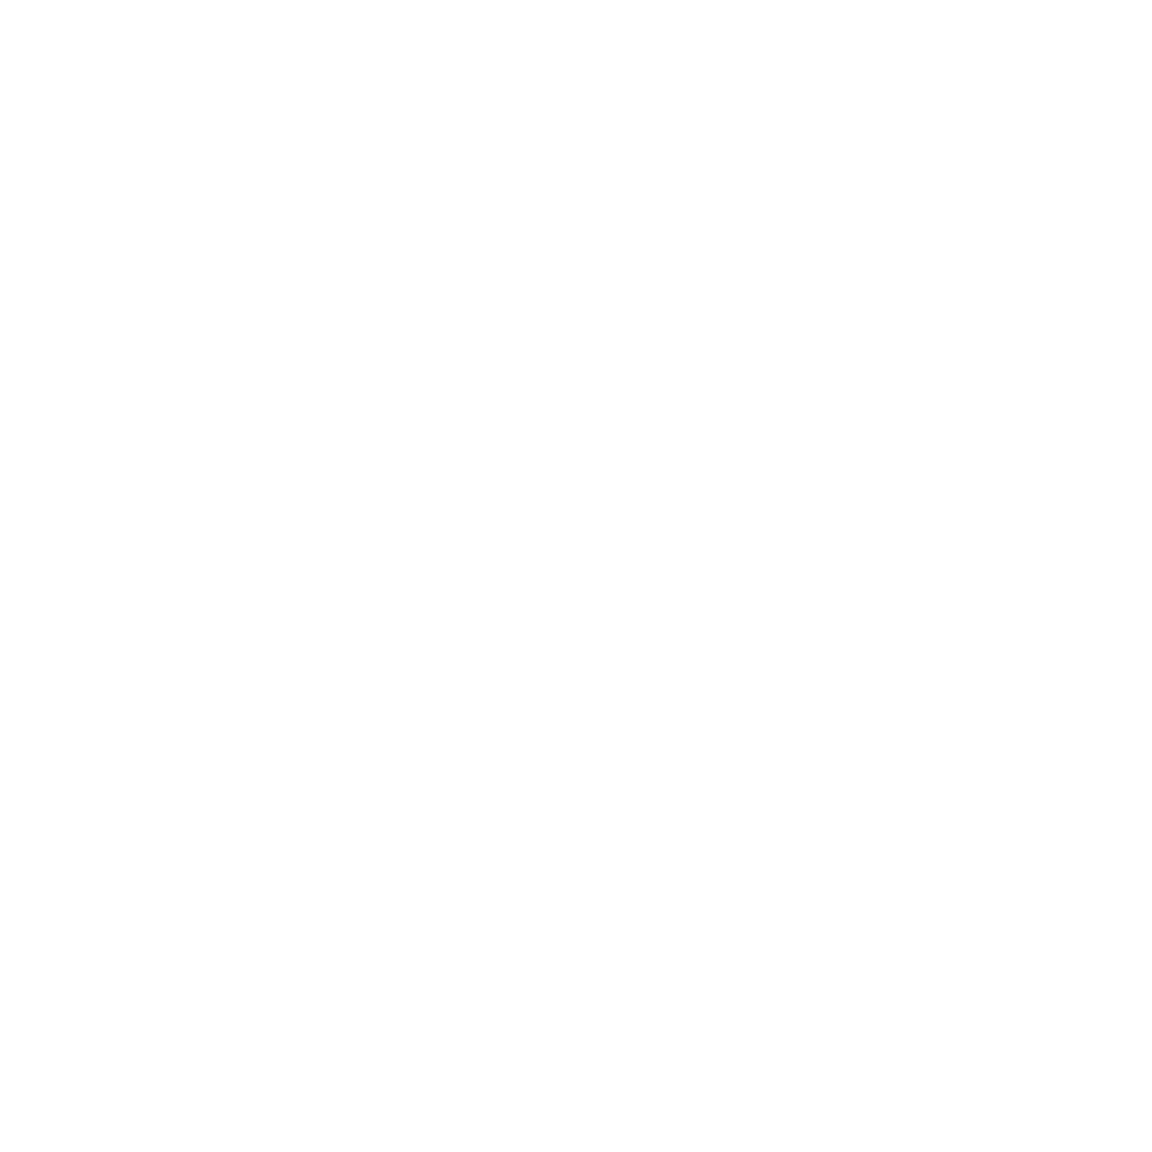

<IPython.core.display.Javascript object>


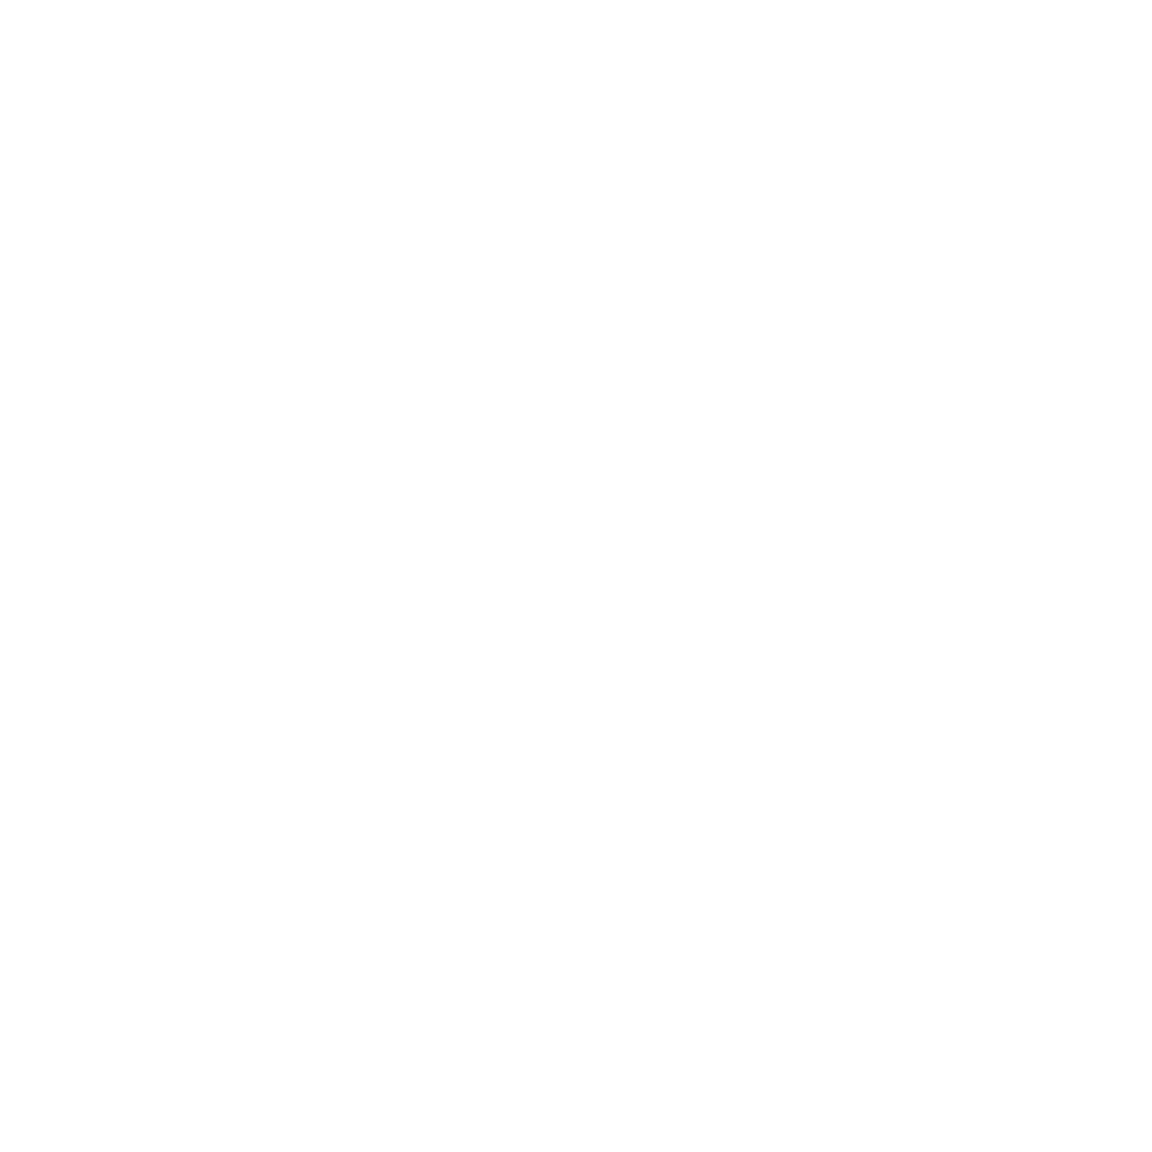

<IPython.core.display.Javascript object>


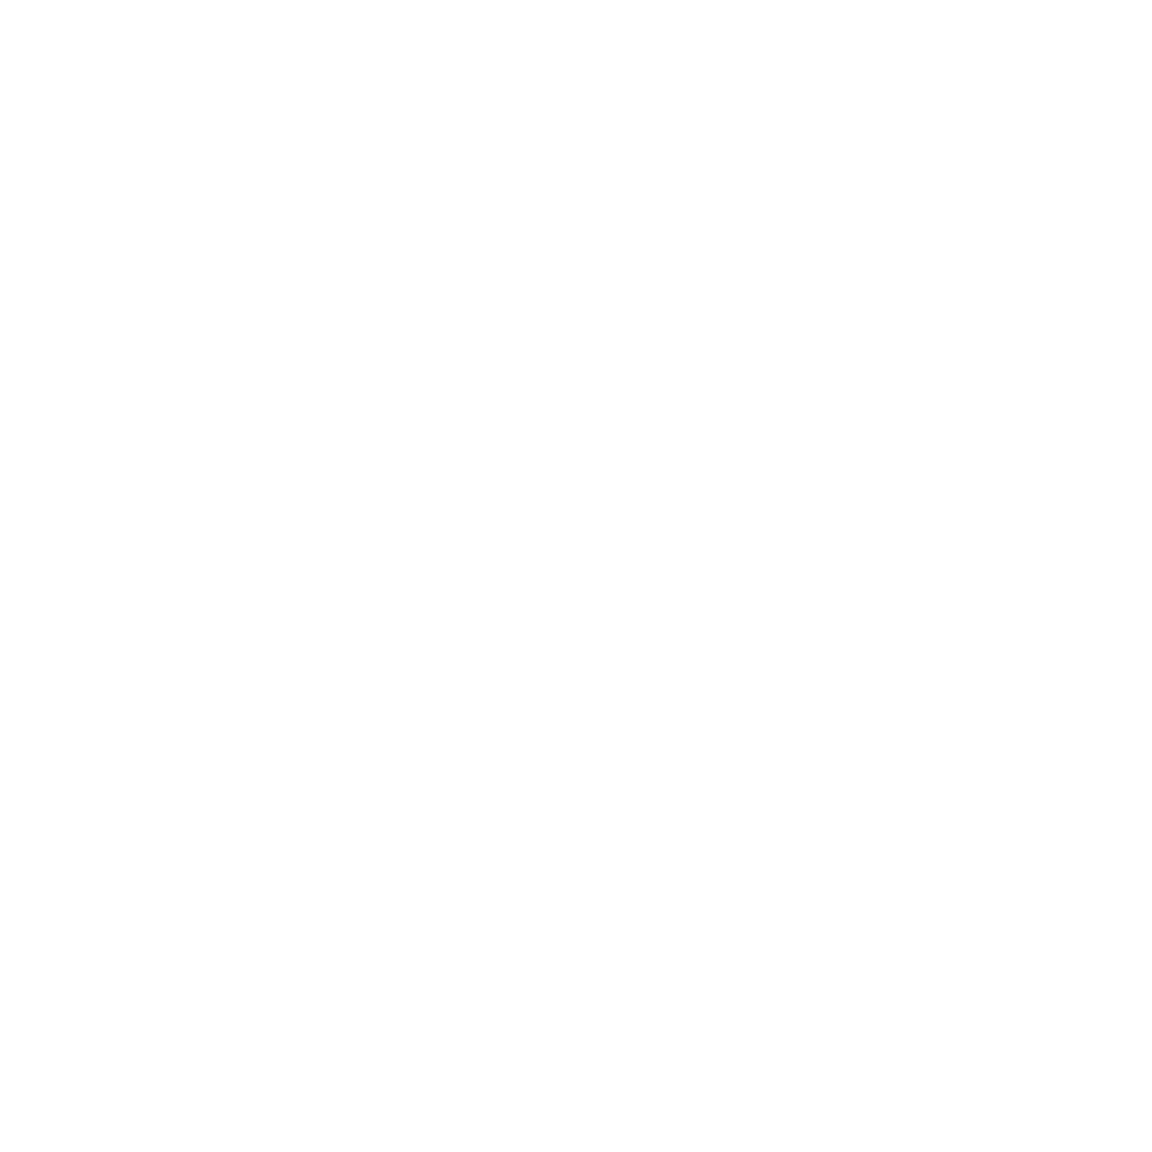

<IPython.core.display.Javascript object>


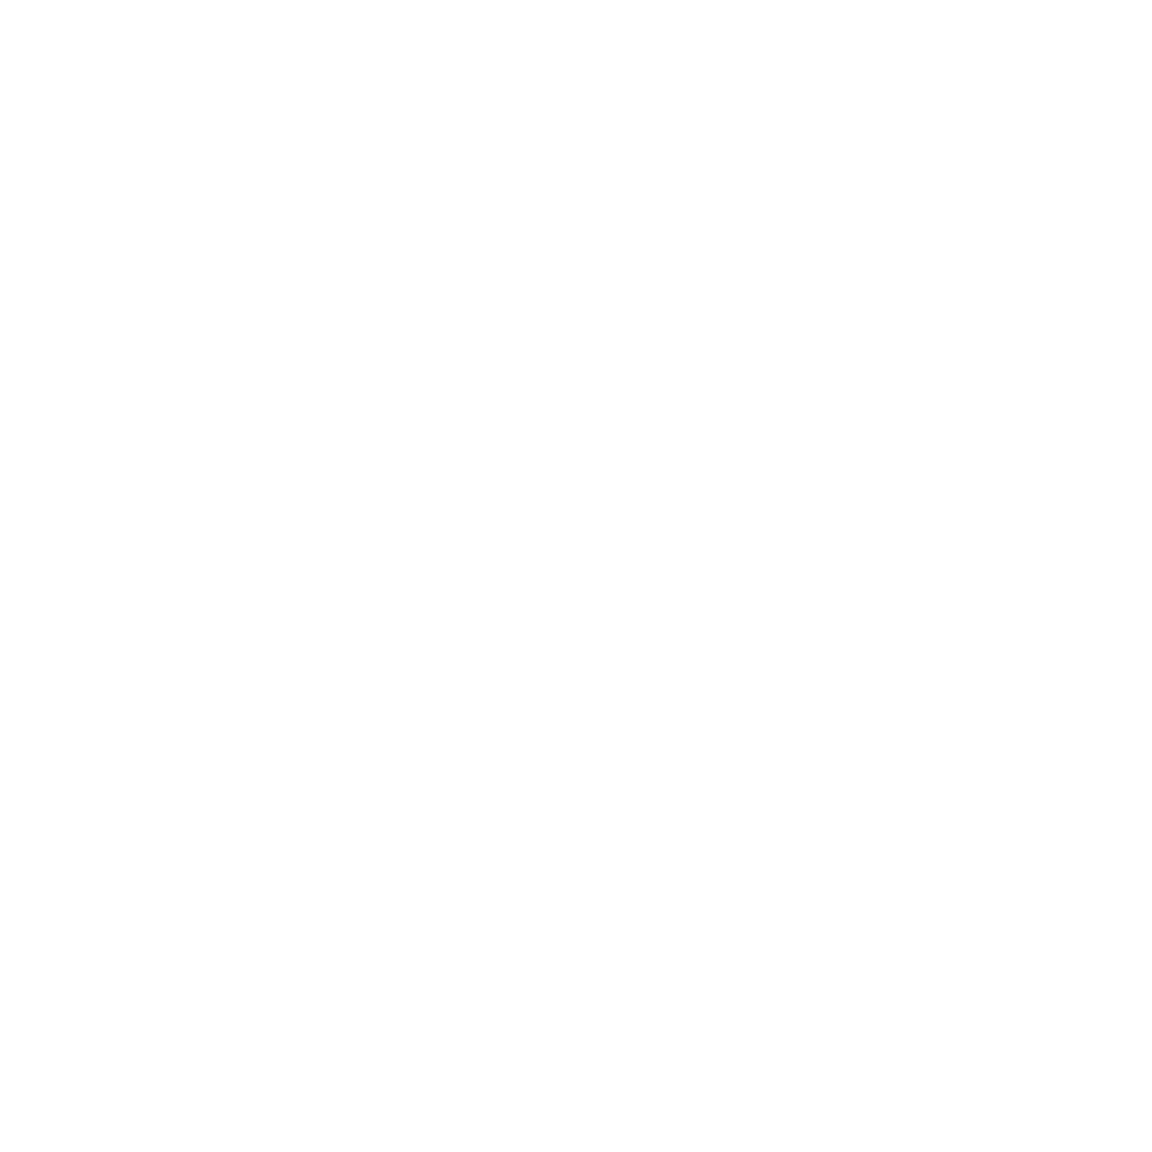

<IPython.core.display.Javascript object>


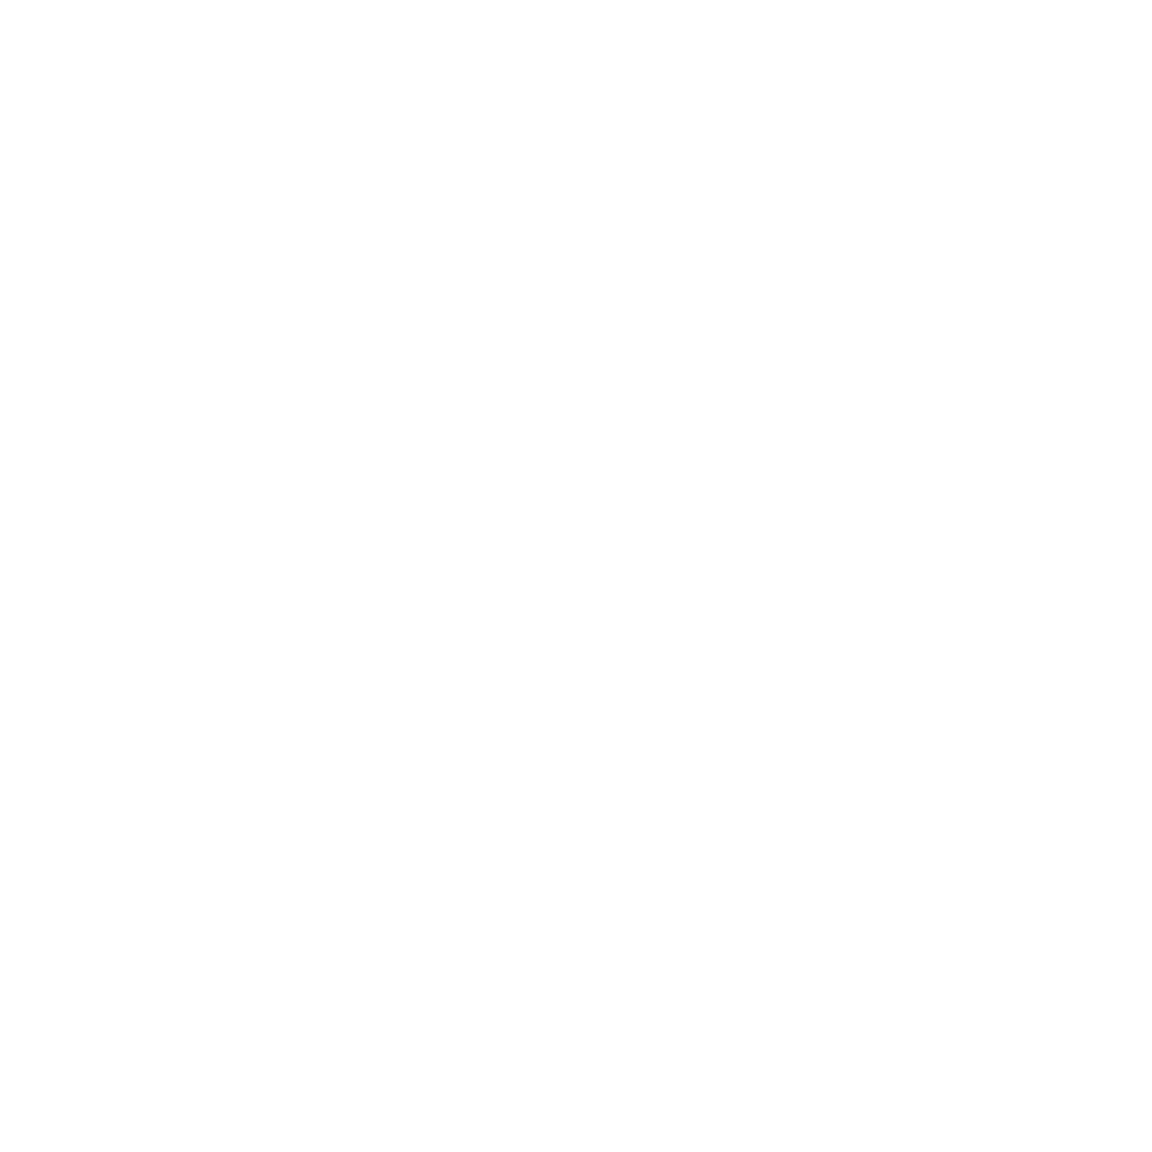

<IPython.core.display.Javascript object>


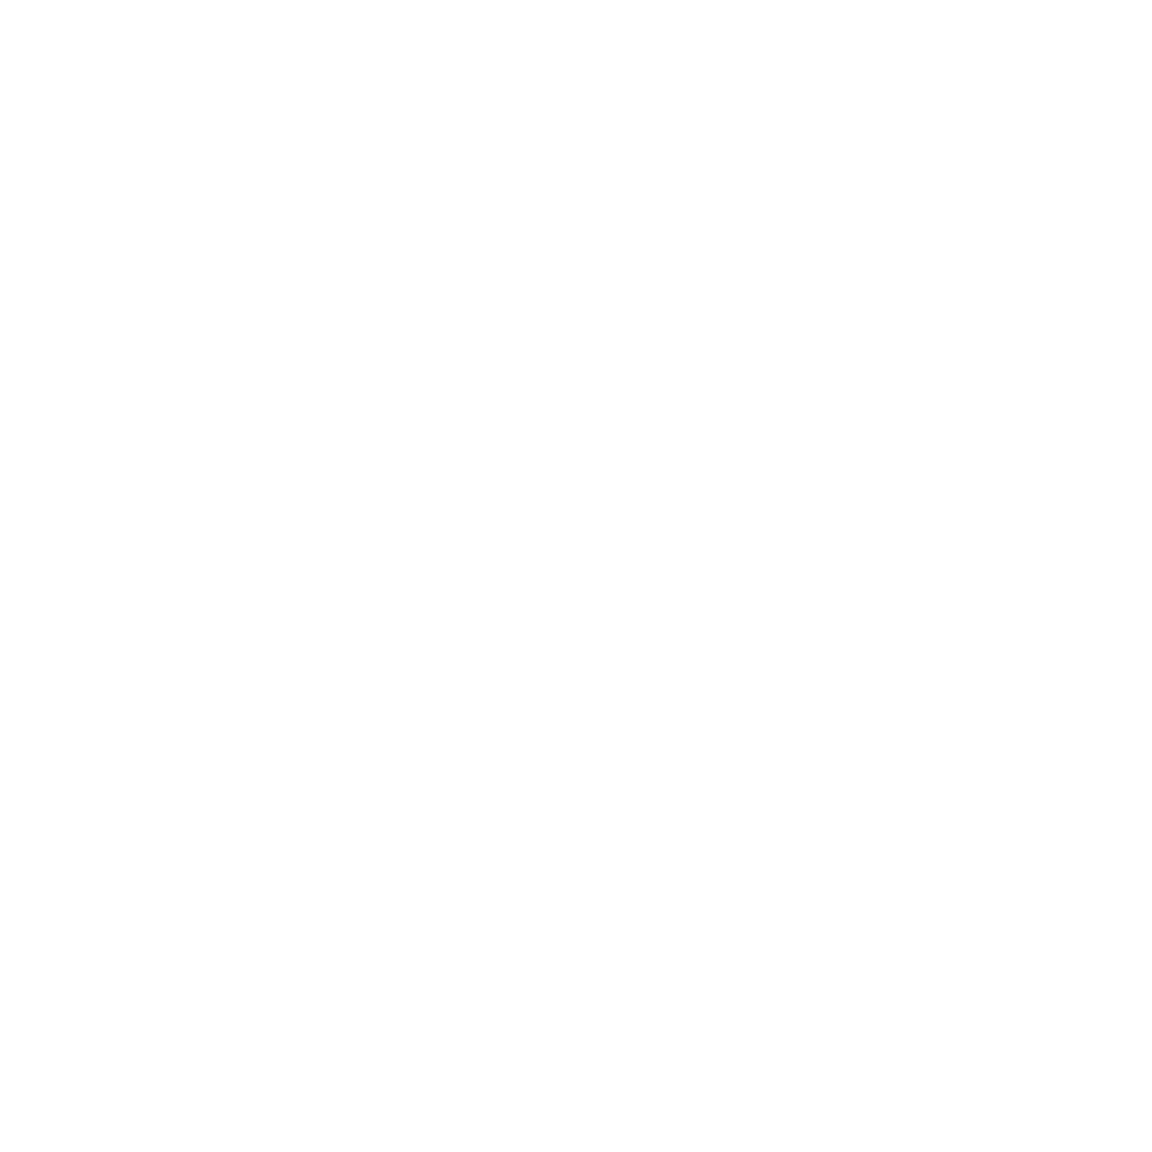

<IPython.core.display.Javascript object>


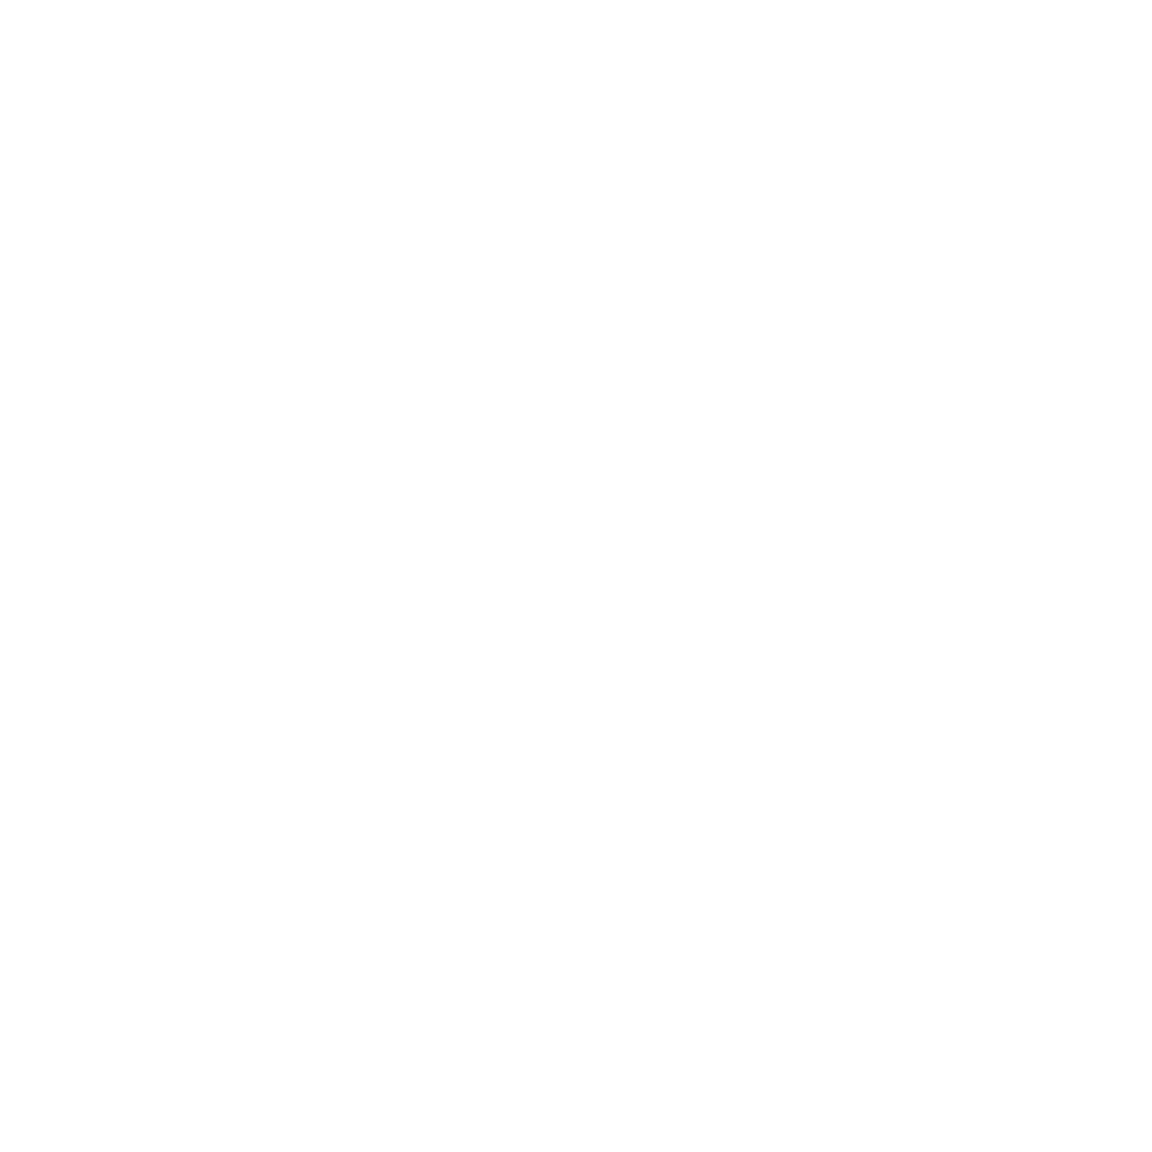

<IPython.core.display.Javascript object>


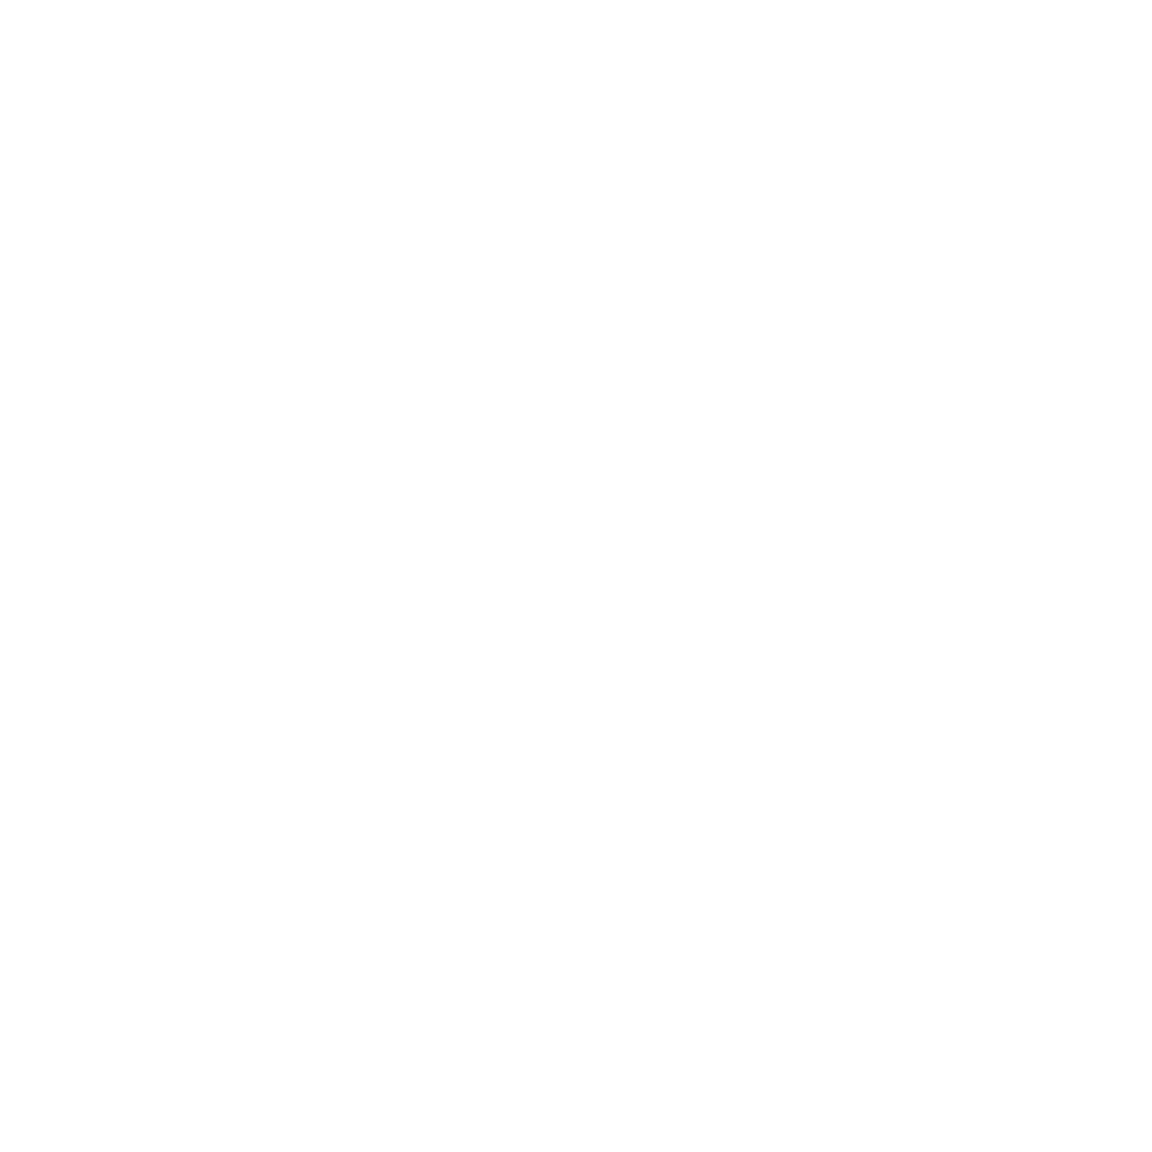

<IPython.core.display.Javascript object>


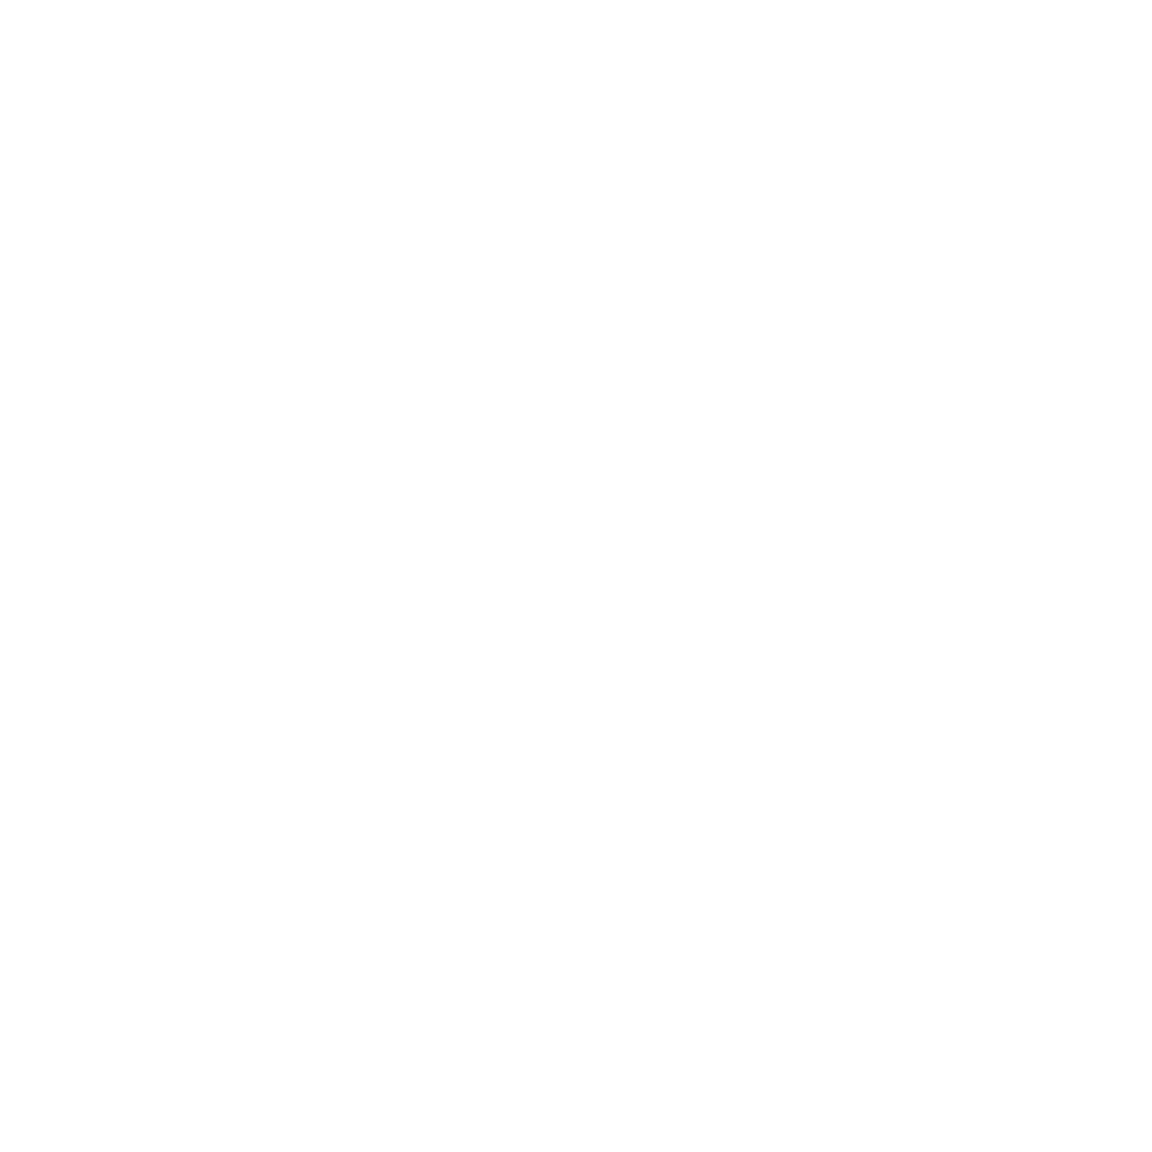

<IPython.core.display.Javascript object>


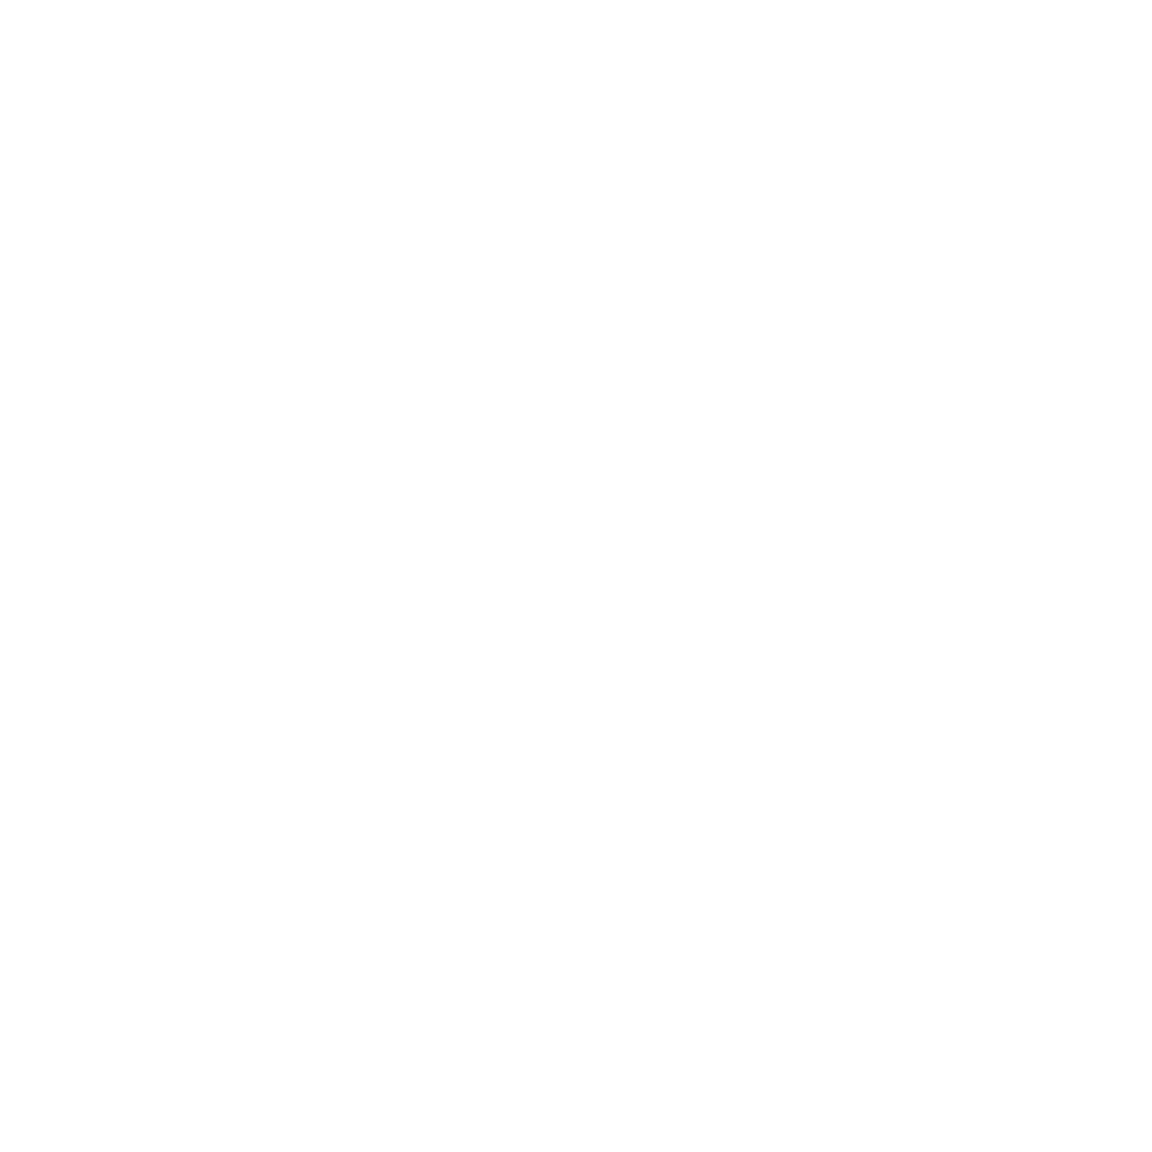

<IPython.core.display.Javascript object>


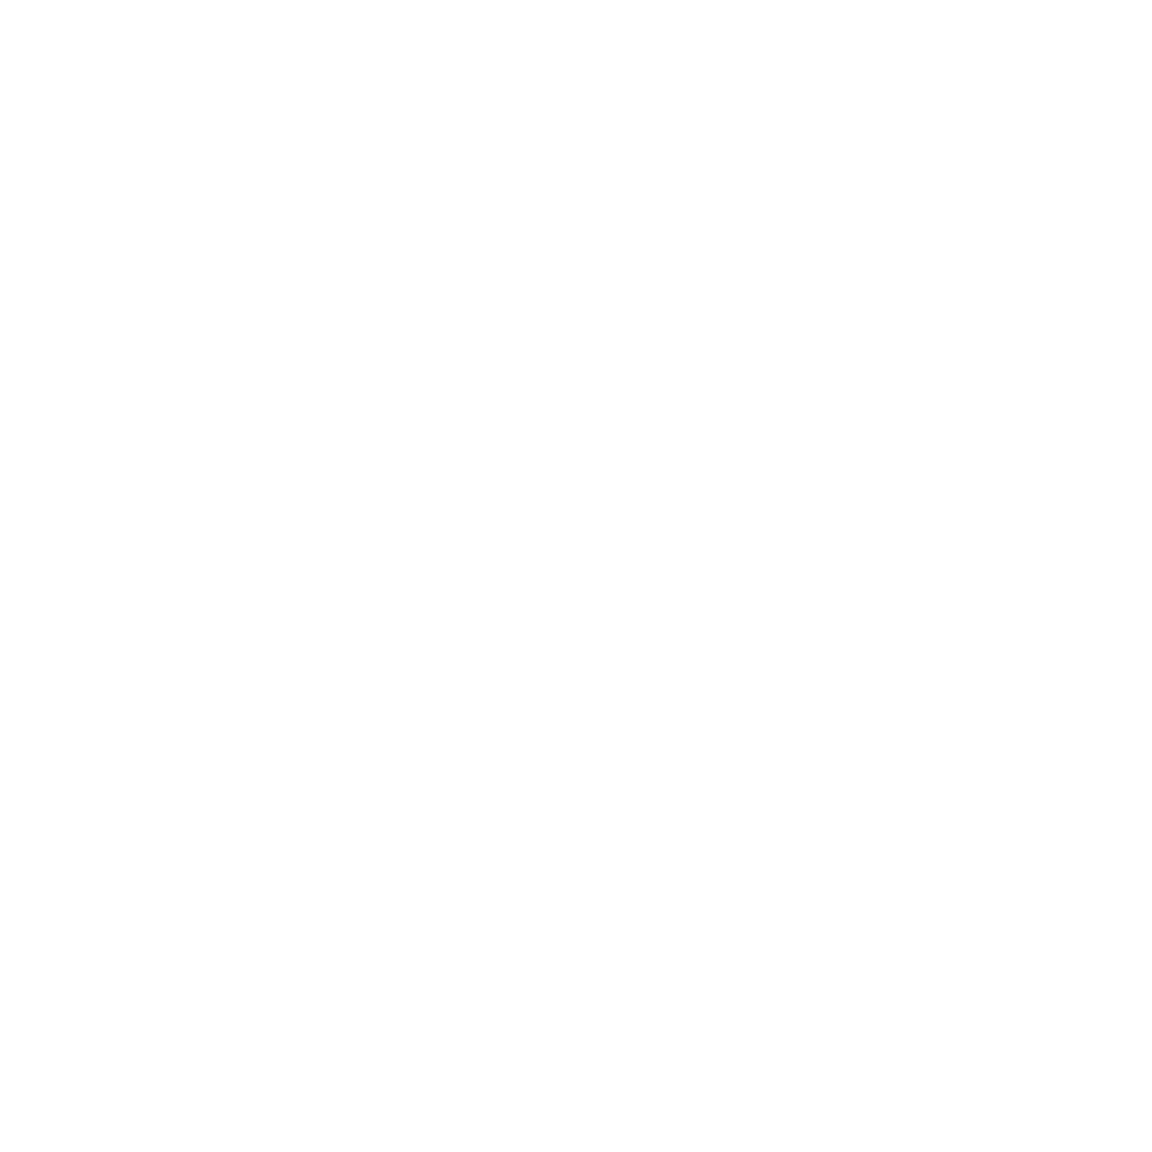

<IPython.core.display.Javascript object>


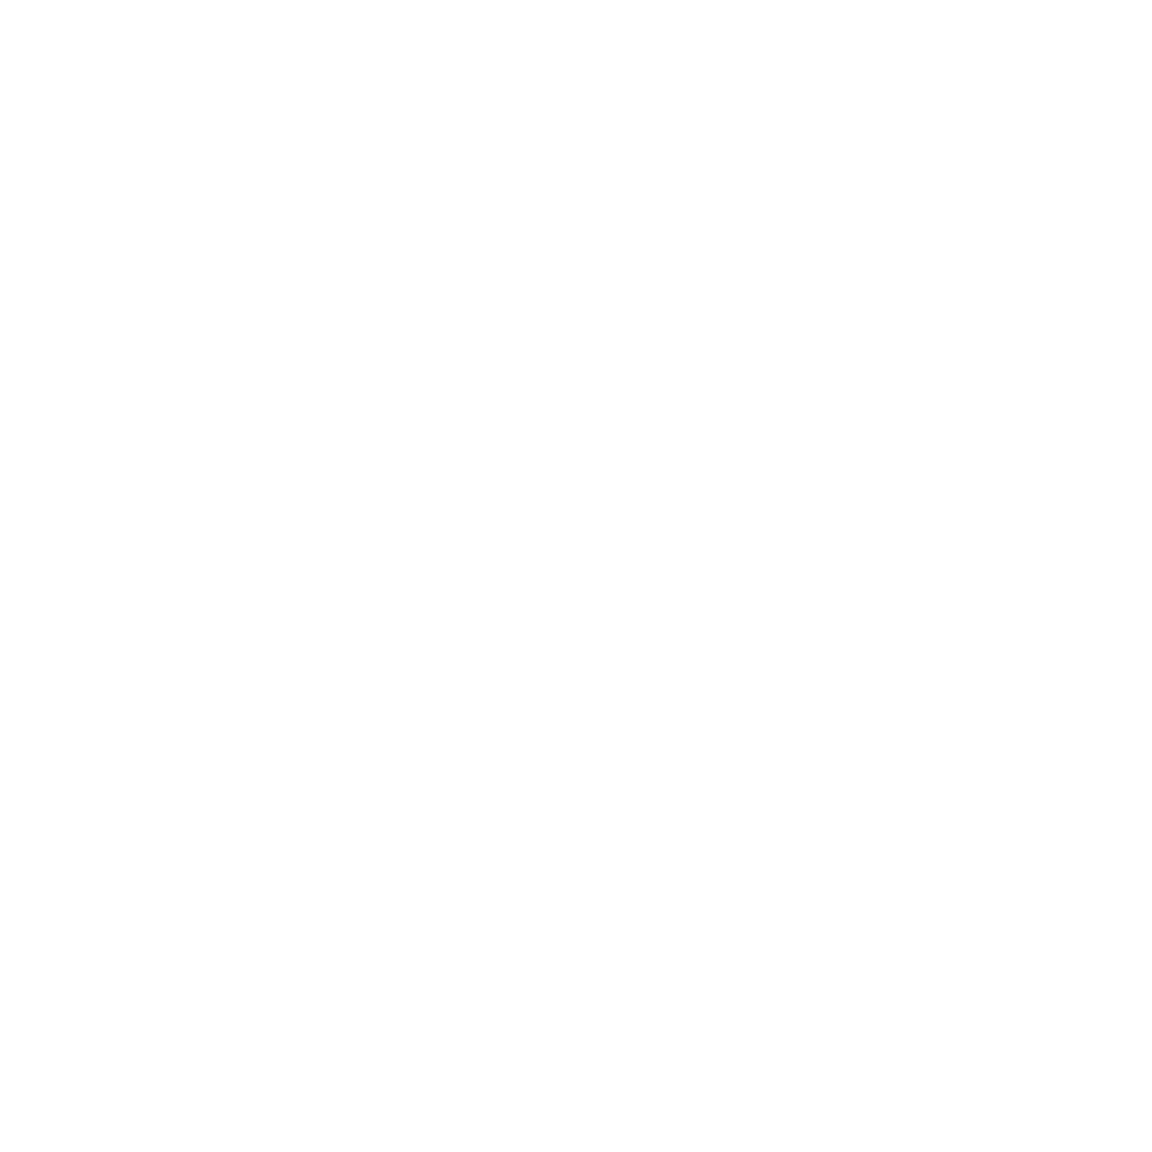

<IPython.core.display.Javascript object>


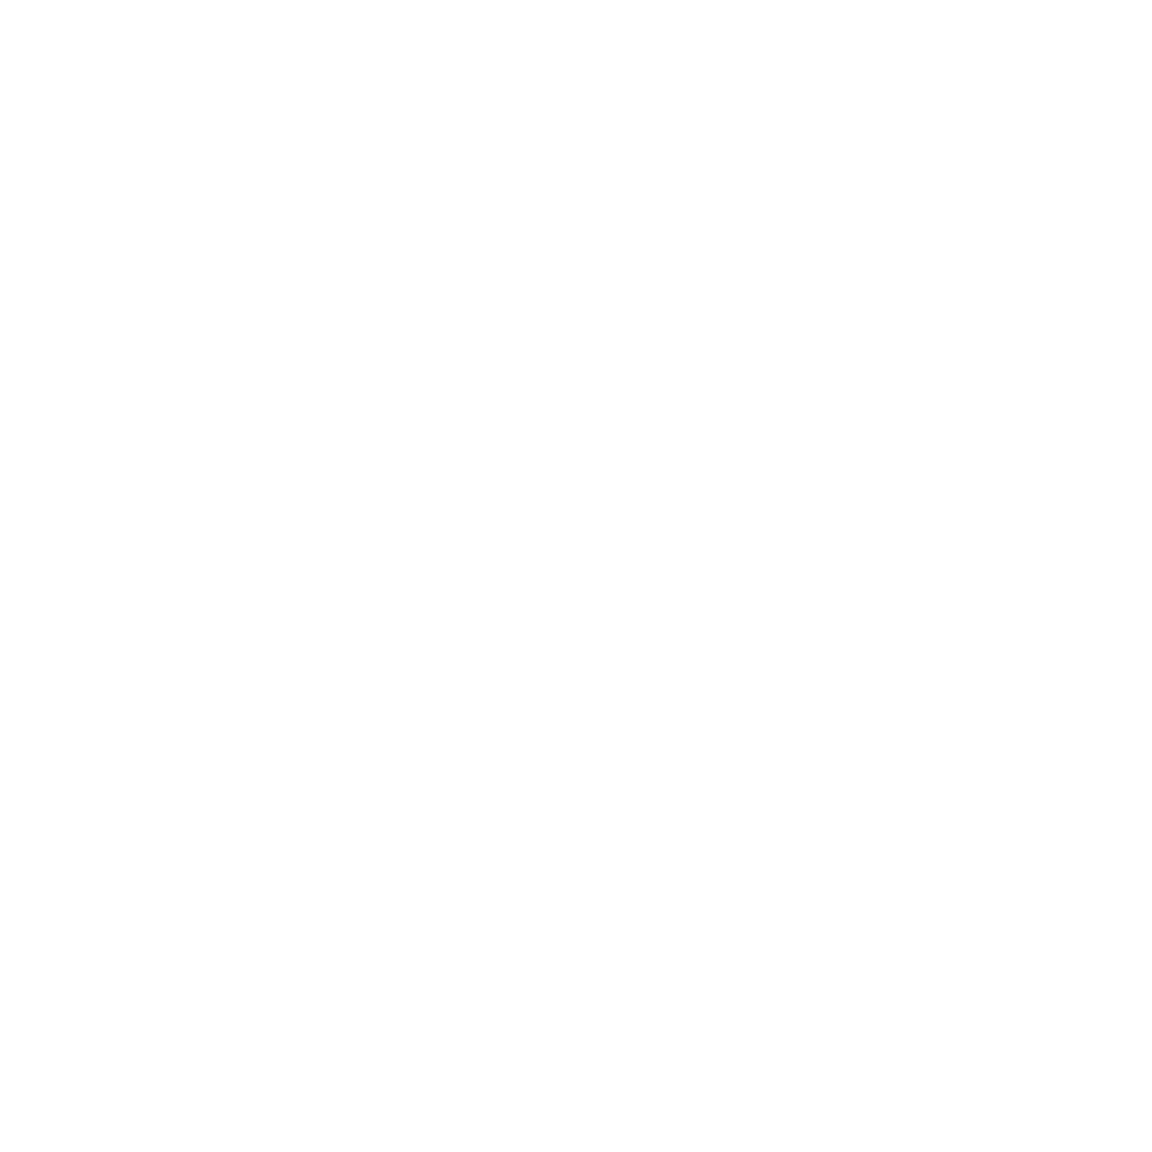

<IPython.core.display.Javascript object>


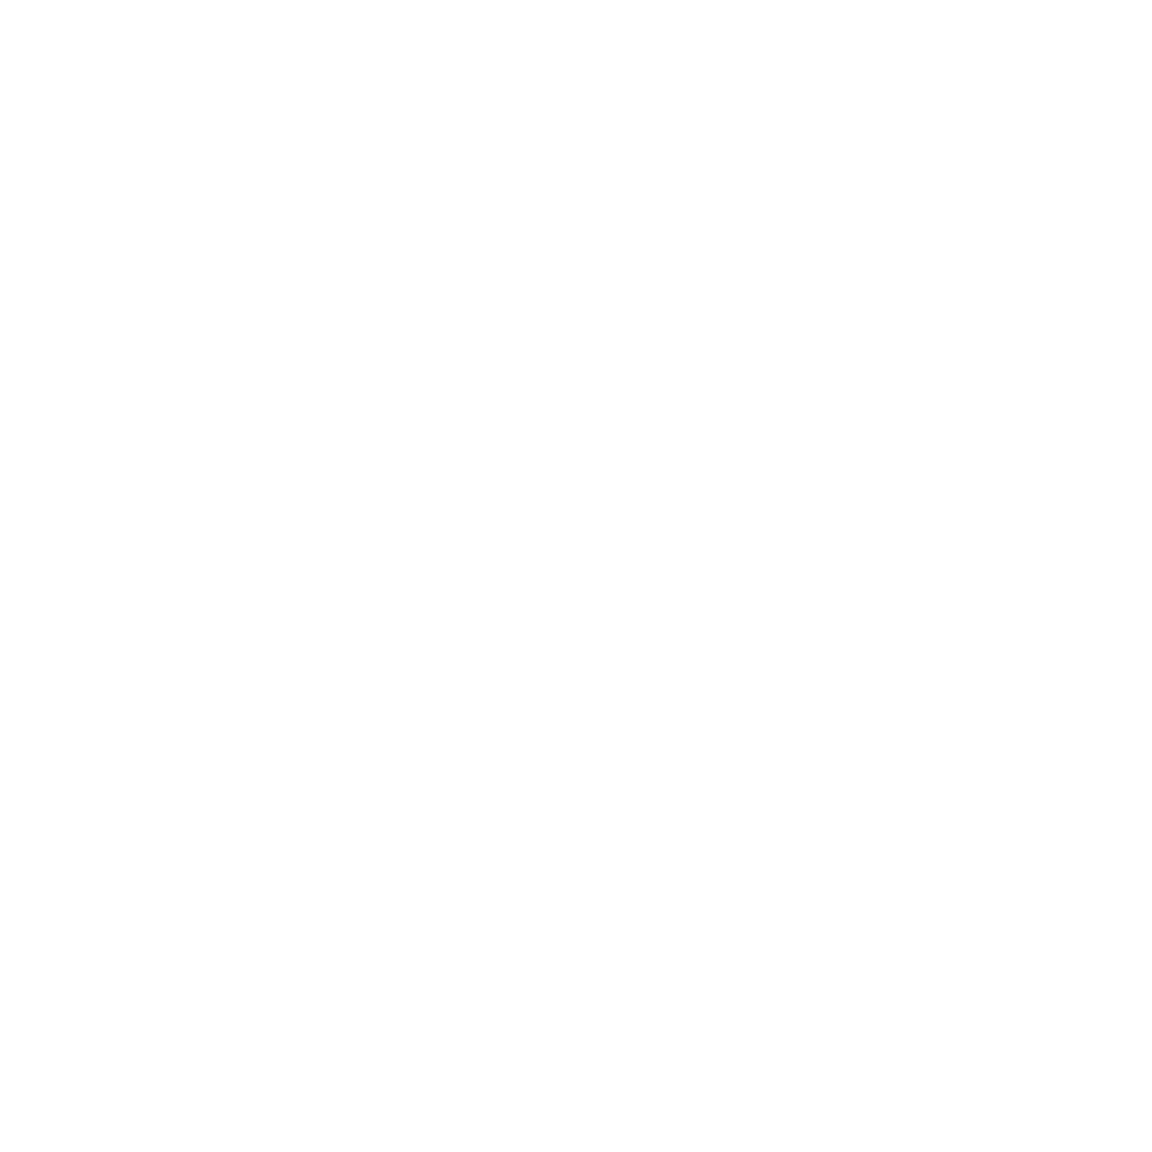

<IPython.core.display.Javascript object>


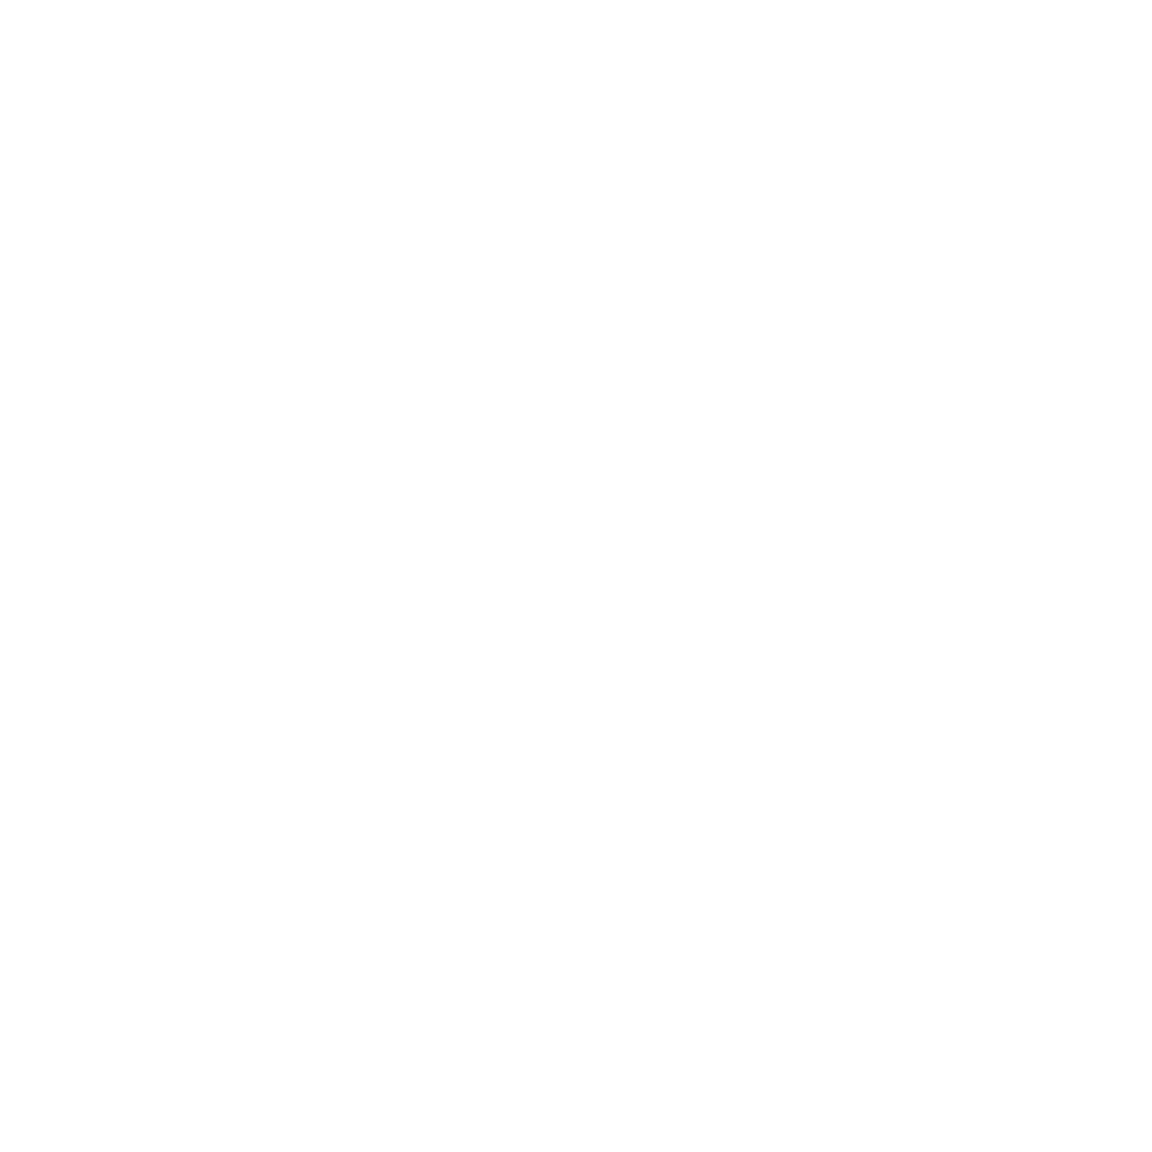

<IPython.core.display.Javascript object>


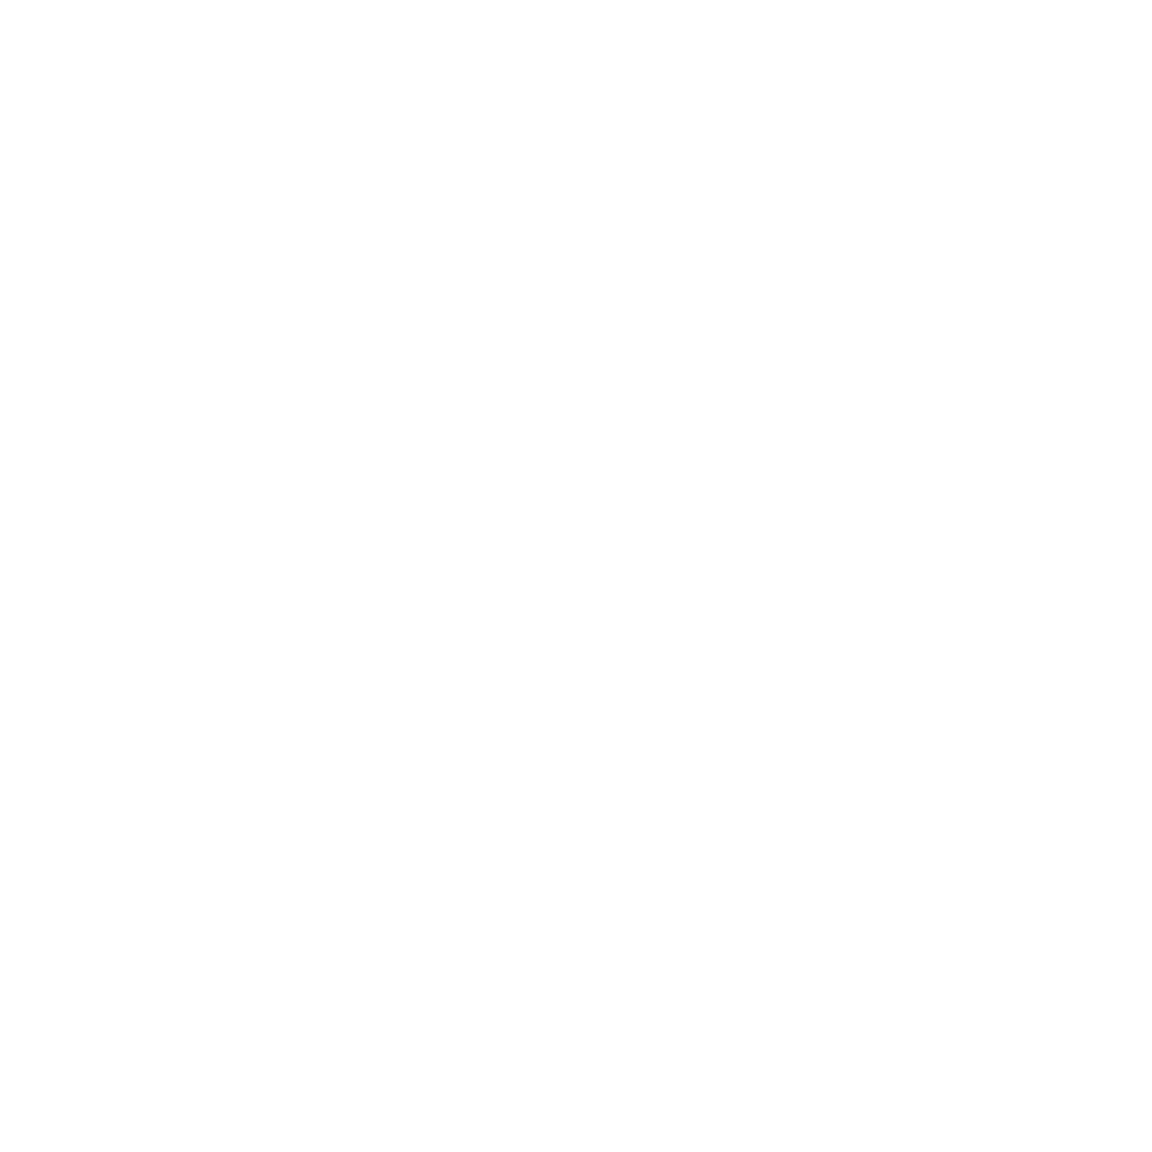

<IPython.core.display.Javascript object>


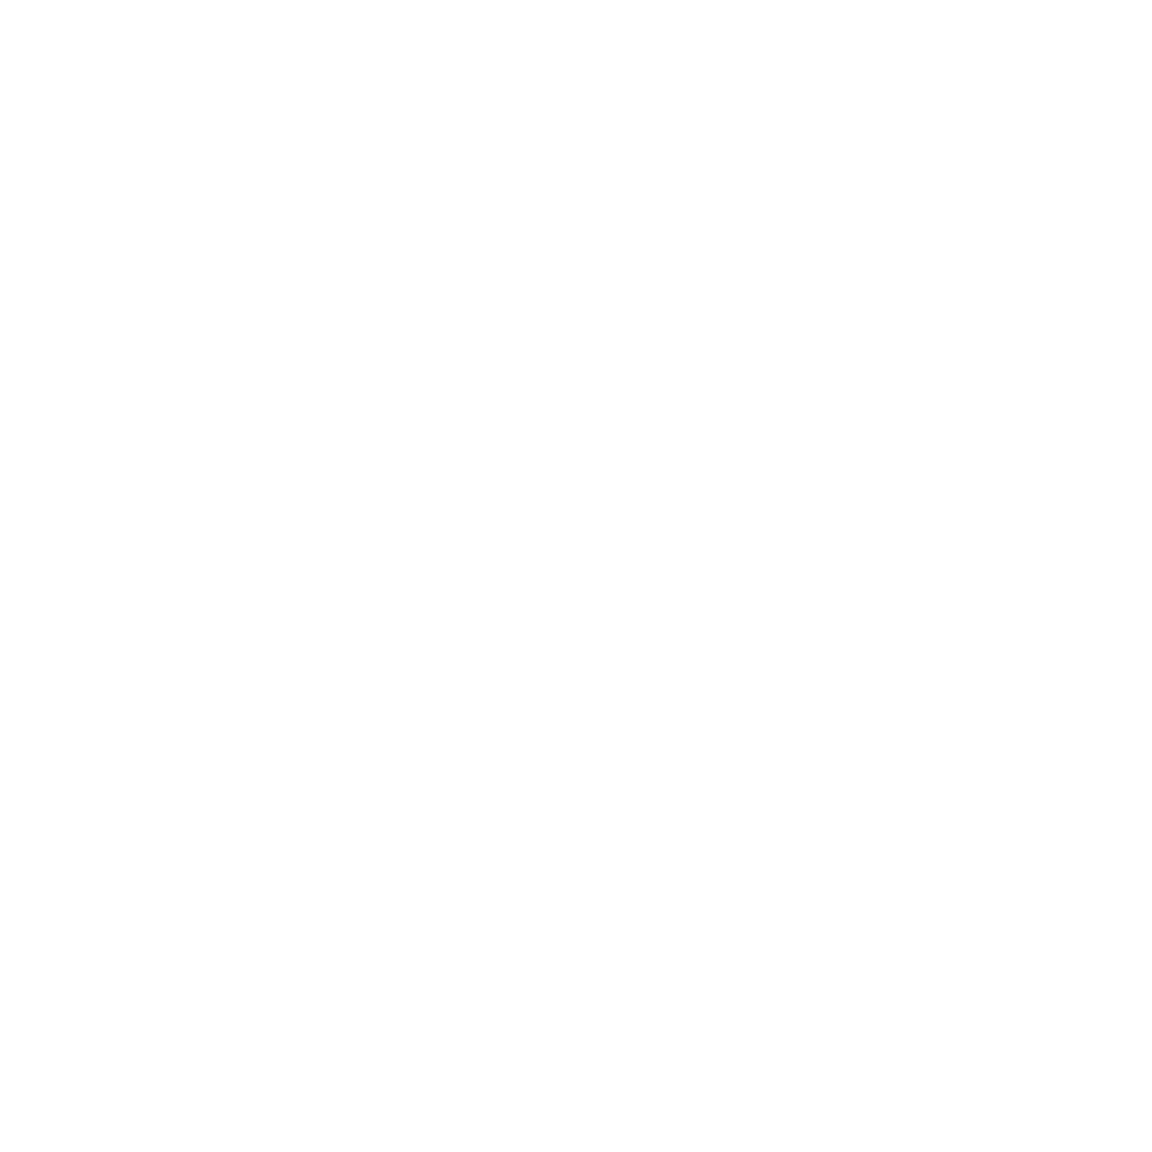

<IPython.core.display.Javascript object>


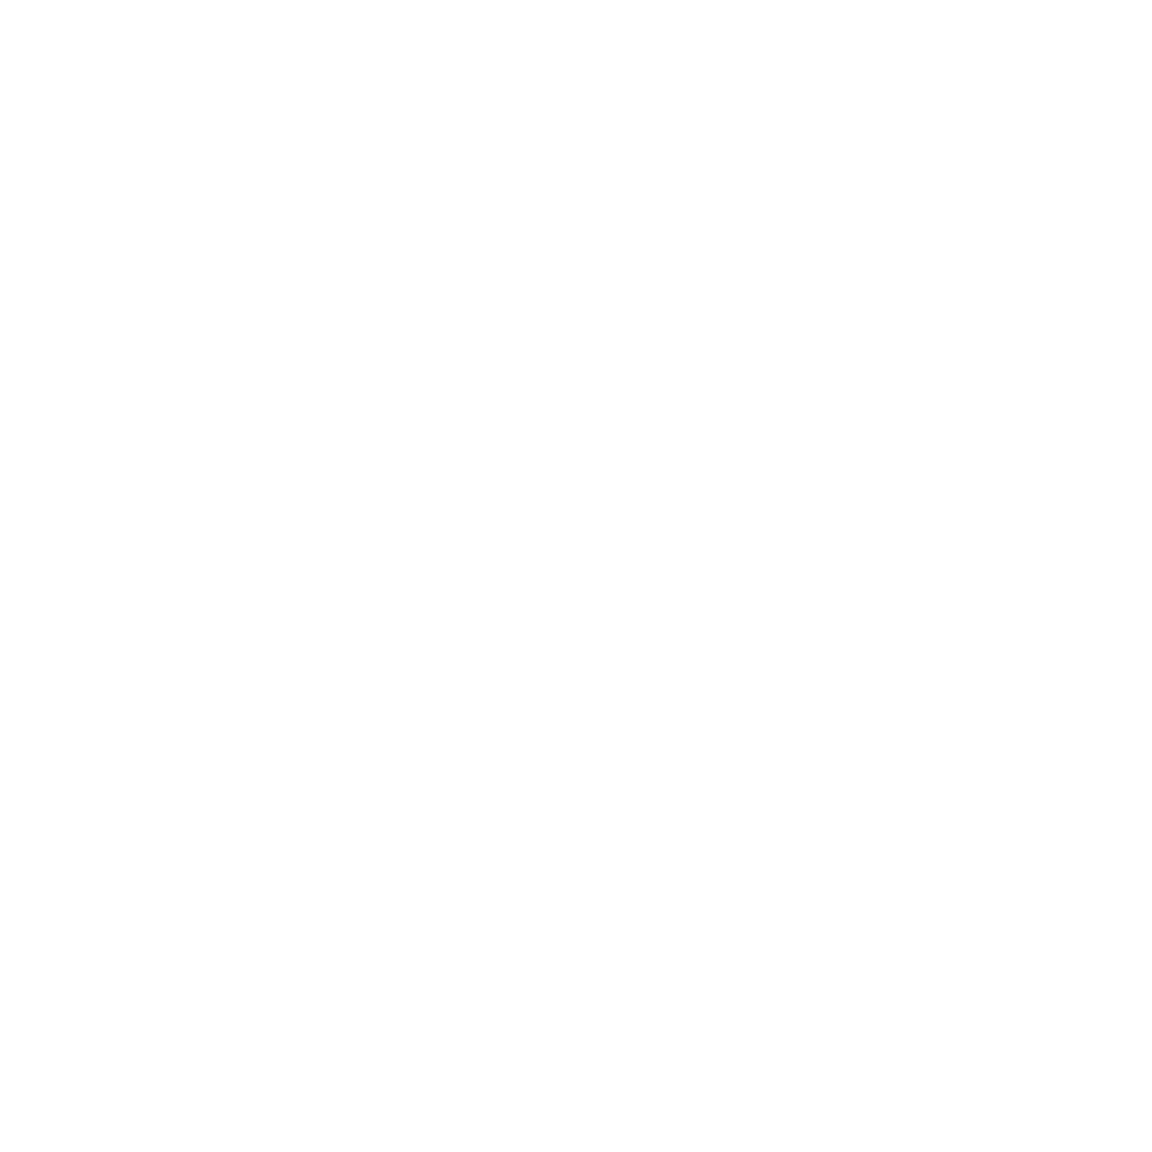

<IPython.core.display.Javascript object>


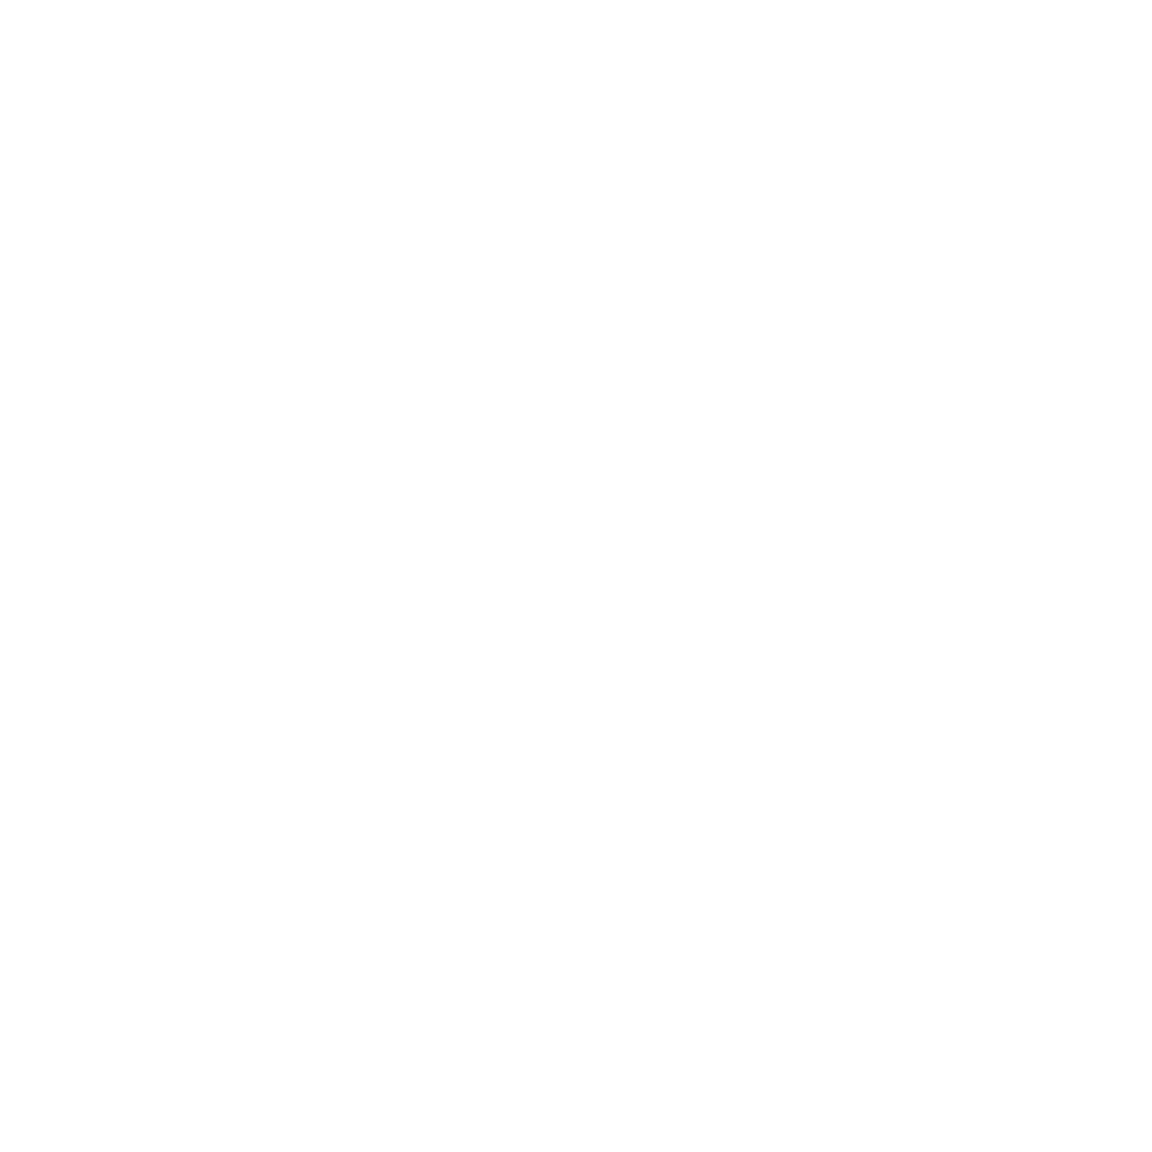

<IPython.core.display.Javascript object>


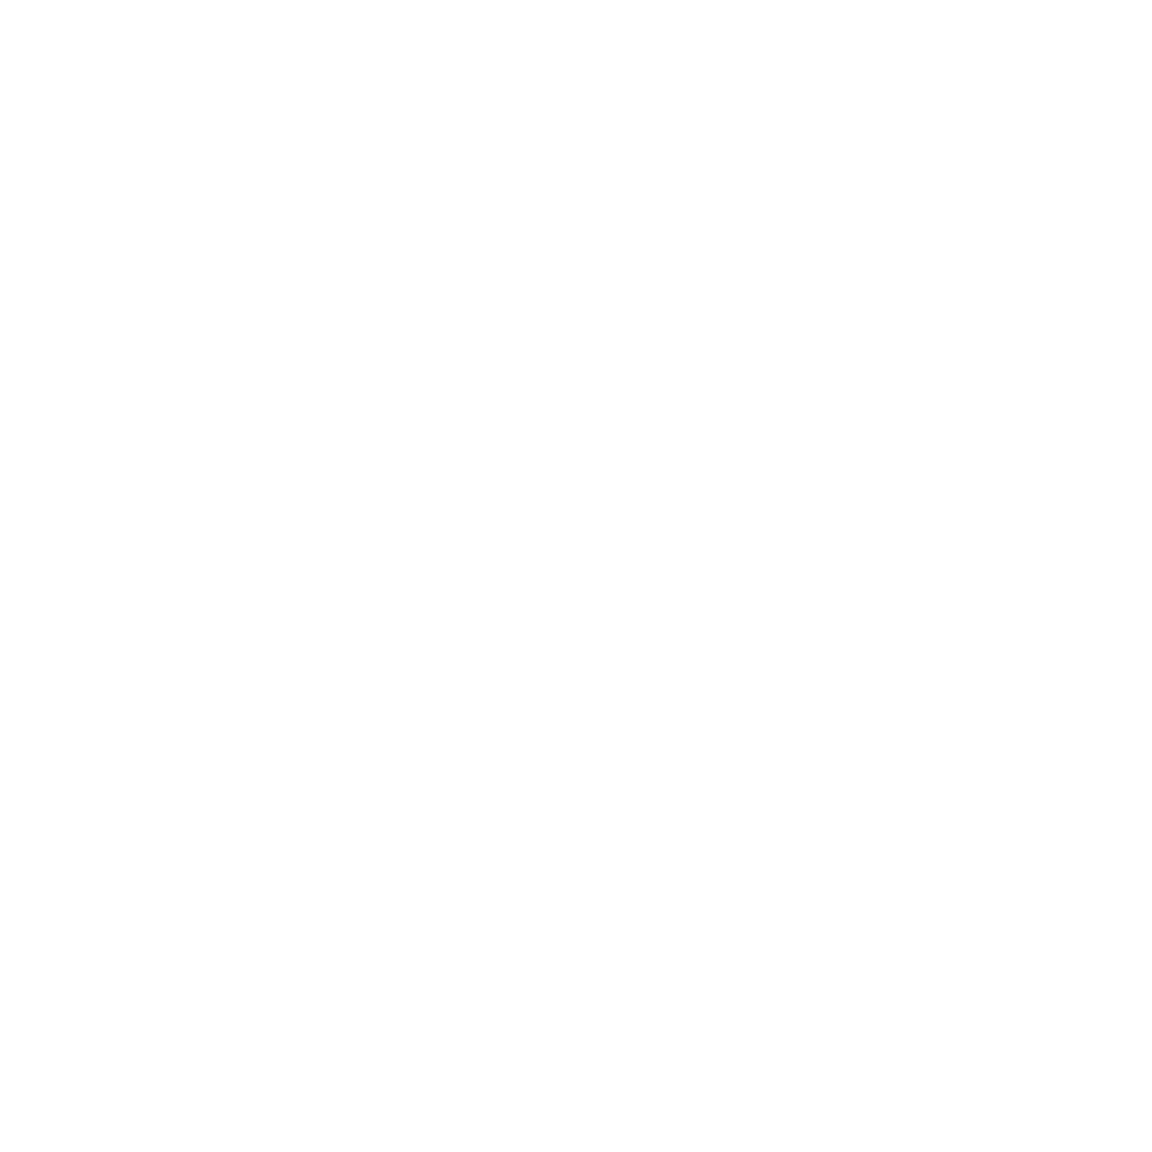

<IPython.core.display.Javascript object>


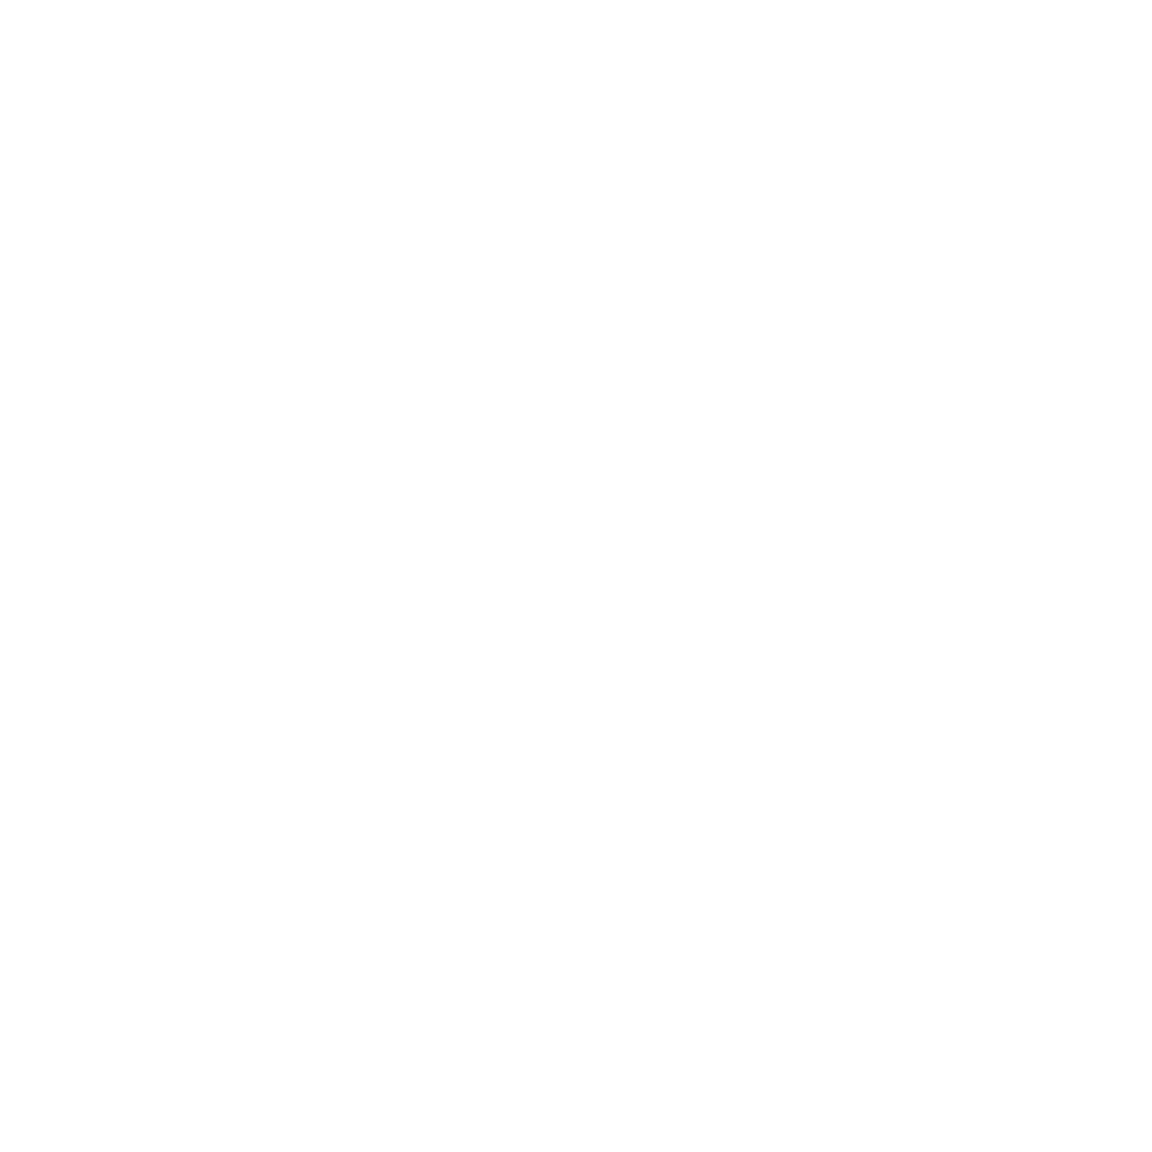

<IPython.core.display.Javascript object>


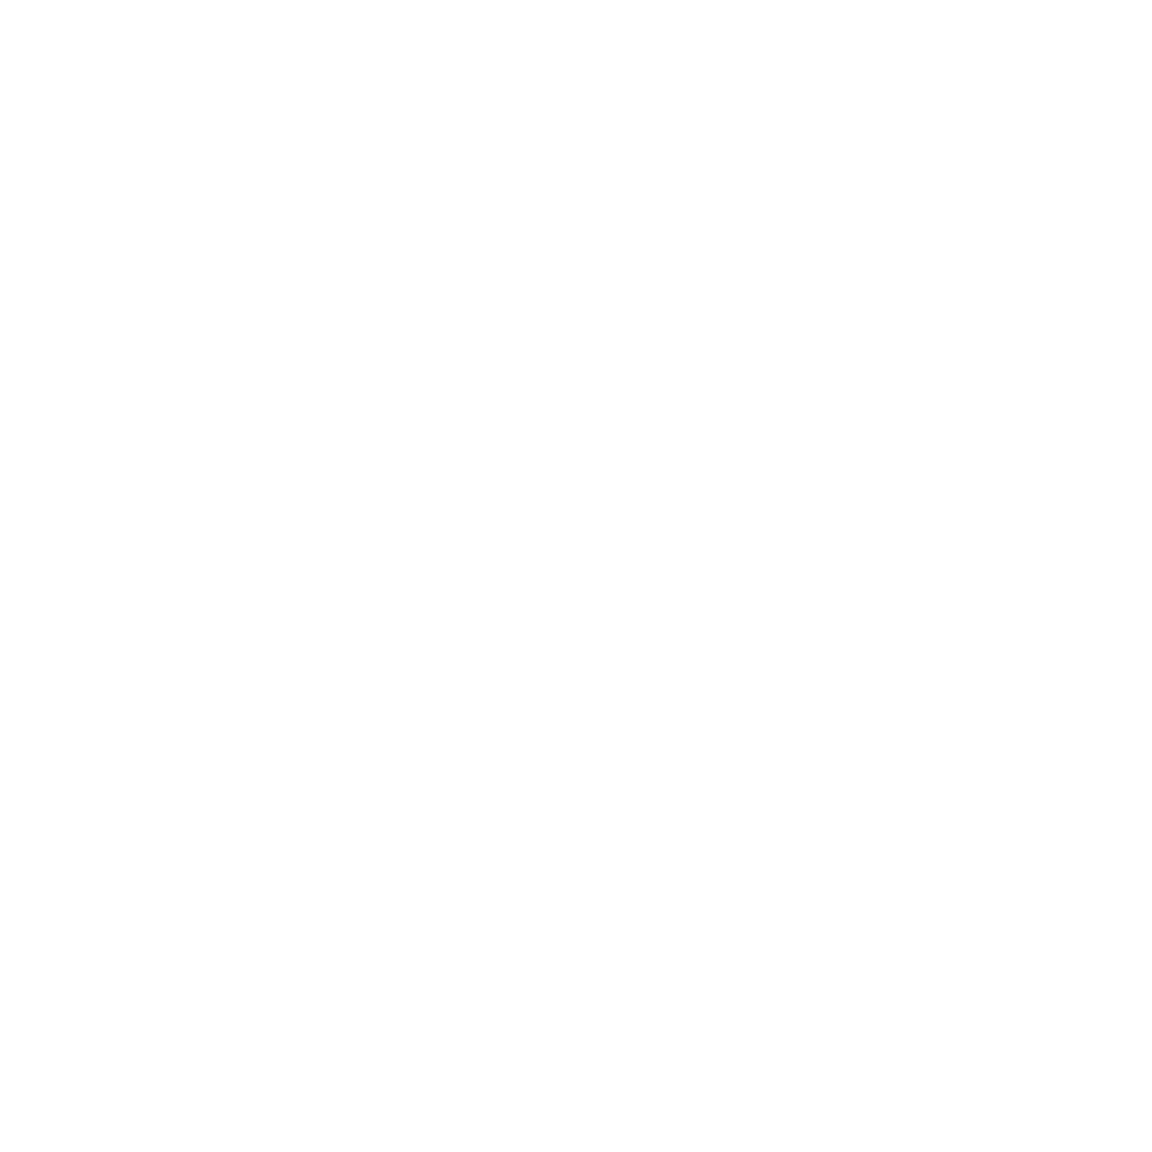

<IPython.core.display.Javascript object>


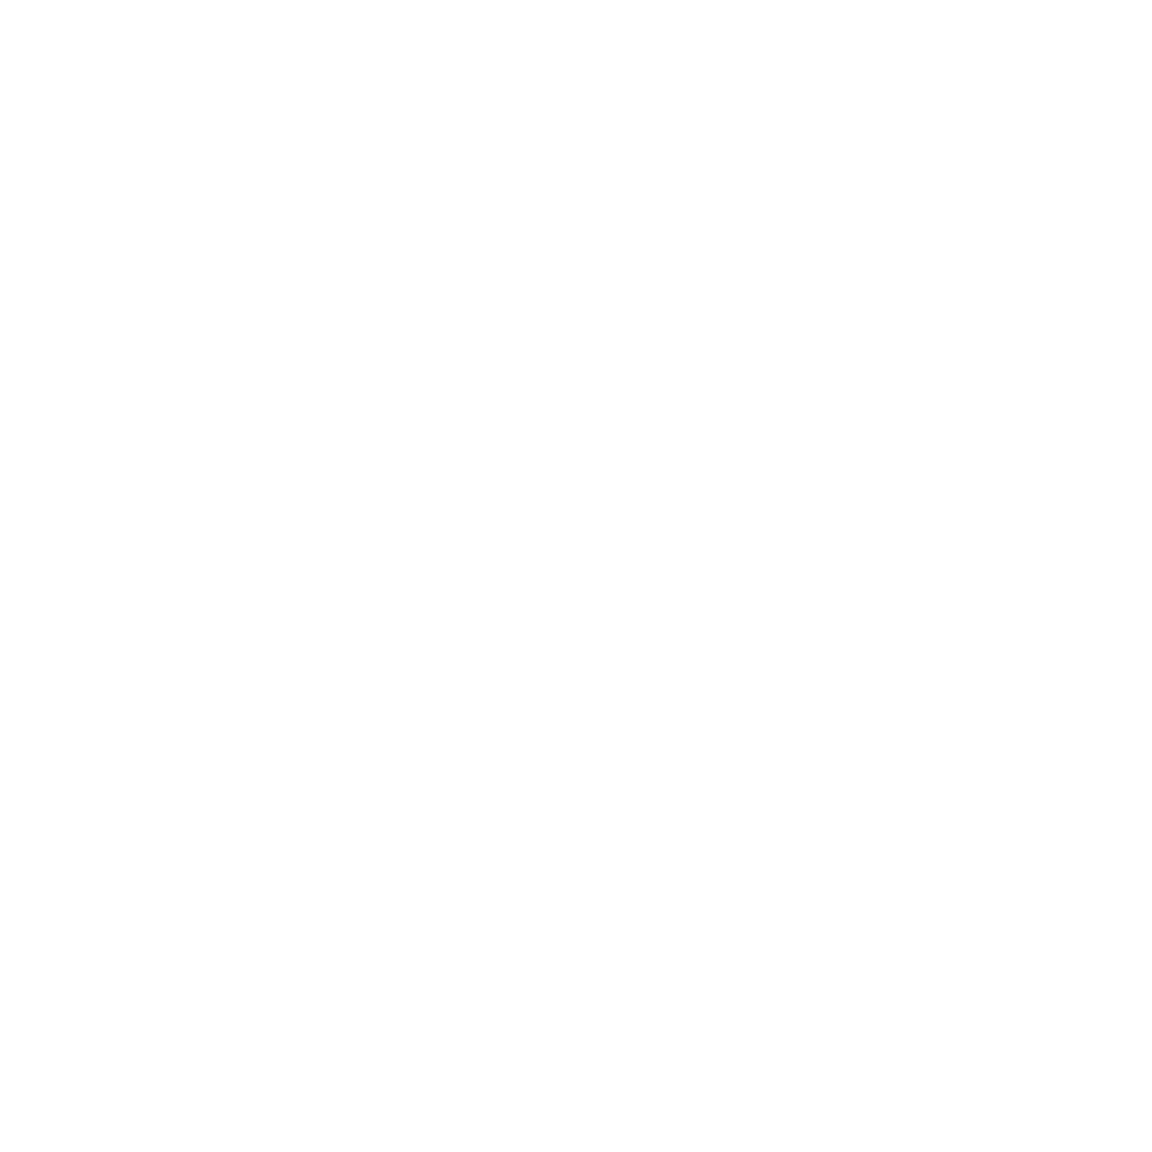

<IPython.core.display.Javascript object>


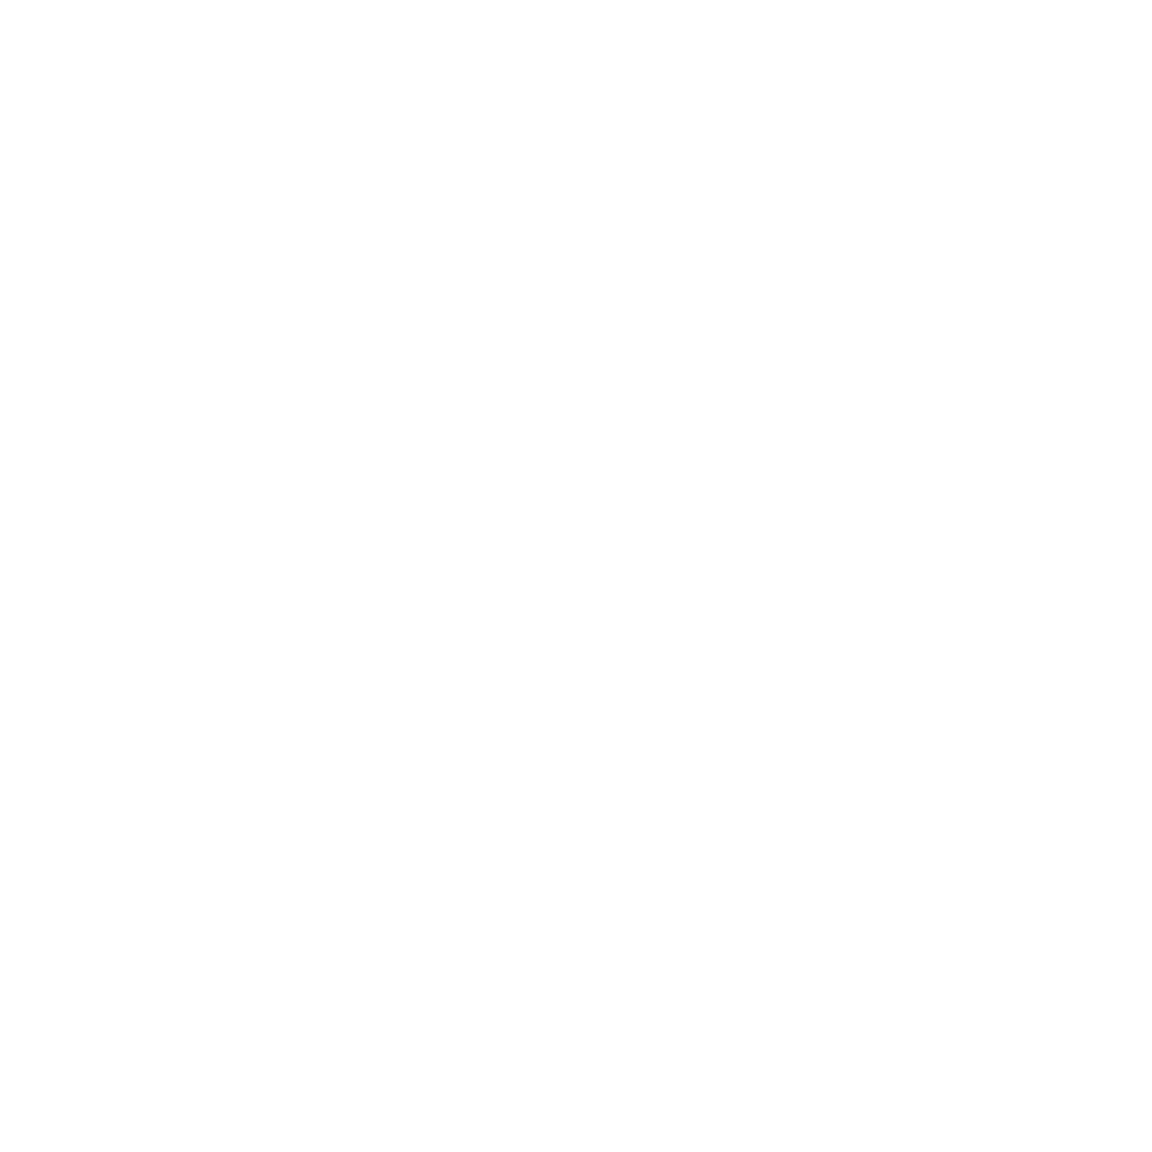

In [58]:
# Draw the ten petals, color them based on masks
for i in petal_locs:
    for j in range(3):
        pos_data = read_pos_data(i, j)
        fig, ax = plt.subplots(figsize=(16, 16))
        # plt.plot(pos1['col1'], pos1['col2'], '.')
        for petal_loc in petal_locs:
            xco, yco = getpostriangle(petal_loc)
            plt.plot(xco, yco, 'k--')
            petmask = MakePetalMask(pos_data['fvc_x'], pos_data['fvc_y'], petal_loc)
            plt.plot(pos_data['fvc_x'][petmask], pos_data['fvc_y'][petmask], '.')
        ax.set_aspect('equal')
        plt.title("Map of petal boundaries")
        fig.savefig(f'petal_boundary_{i}_{j}.pdf', bbox_inches='tight')
        plt.close('all')

In [18]:
def MakePetalMask(x, y, petnum):
    '''
    Determine if points (x, y) are in petal petnum
    '''
    # triangle = [[x1,y1],[x2,y2],[x3,y3]]
    xco, yco = getpostriangle(petnum)
    tri = [ [xco[0], yco[0]], [xco[1], yco[1]], [xco[2],yco[2]]]
    x1 = tri[0][0]
    y1 = tri[0][1]
    x2 = tri[1][0]
    y2 = tri[1][1]
    x3 = tri[2][0]
    y3 = tri[2][1]
    a = ((y2 - y3)*(x - x3) + (x3 - x2)*(y - y3)) / ((y2 - y3)*(x1 - x3) + (x3 - x2)*(y1 - y3))
    b = ((y3 - y1)*(x - x3) + (x1 - x3)*(y - y3)) / ((y2 - y3)*(x1 - x3) + (x3 - x2)*(y1 - y3))
    c = 1 - a - b
    mask = np.zeros(len(x), dtype=bool)
    for i in range(len(x)):
        mask[i] = ((0 <= a[i] <= 1) and (0 <= b[i] <= 1) and (0 <= c[i] <= 1))
    return mask

### Spotmatch

In [20]:
def spotmatch(pos_data, petal_loc, exp_no=0, ref_exp_no=None, n_pass=6, verbose=False):
    '''each petal received three exposures, one initial without moving, one after phi move, one after theta move
    exp_no is 0, 1, or 2
    ref_exp_no is the known reference, None, 0, 1, or 2, where None means using the (distorted) nominal position'''

    def process_spot(ref_data, row, match_radius):
        rs = np.linalg.norm(ref_data - row.values, axis=1)  # ordered by data_petal indices
        rs_min = np.nanmin(rs)
        if rs_min <= match_radius:
            # found a best match w.r.t. nominal positions (for exp_no = 0) 
            # or preivously identified spots (for exp_no > 0)
            device_id = data_petal.index[np.where(rs==rs_min)].values[0]
            device_type = data_petal.loc[device_id, 'device_type']
            if device_type != 'POS':
                if data.loc[device_id, f'matched_{petal_loc}{exp_no}'] and verbose:
                    print(f'Duplicate fiducial spot matched for {device_id} at: {row.values}')
            data.loc[device_id, f'matched_{petal_loc}{exp_no}'] = True
            data.loc[device_id, f'fvc_x_{petal_loc}{exp_no}'] = row.values[0]
            data.loc[device_id, f'fvc_y_{petal_loc}{exp_no}'] = row.values[1]
            data.loc[device_id, f'err_px_{petal_loc}{exp_no}'] = rs_min
            matched_row_indices.add(j)  # add to matched set for skipping this row on next pass
            if device_type == 'POS':
                unmatched_ids.remove(device_id)  # remove from unmatched set
                # remove from 'nominal' obs_xy_pixel data to avoid interference, keep FID data
                data_petal.drop(device_id, inplace=True)
            return True, rs_min
        else:
            return False, rs_min

    match_radii = [10, 15, 20, 25, 35, 50]  # in pixels
    data_petal = data[data['petal_loc'] == petal_loc].copy()
    pet_mask = MakePetalMask(pos_data['fvc_x'].values, pos_data['fvc_y'].values, petal_loc)
    pos_data = pos_data[pet_mask]
    n0 = len(pos_data)
    print(f'petal_loc = {petal_loc}, exp_no = {exp_no}, matching {n0} FVC spots...')
    data.loc[data_petal.index, f'matched_{petal_loc}{exp_no}'] = False
    unmatched_ids = set(data_petal.index)
    matched_row_indices = set()
    for i in range(n_pass):
        match_radius = match_radii[i]
        for j, row in pos_data.iterrows():
            if j in matched_row_indices:
                continue  # this row already matched in the previous pass, skip this row
            if ref_exp_no is None:
                ref_data = data_petal[['obs_x_px', 'obs_y_px']].values
            else:
                ref_data = data_petal[[f'fvc_x_{petal_loc}{ref_exp_no}', f'fvc_y_{petal_loc}{ref_exp_no}']].values
            success, rs_min = process_spot(ref_data, row, match_radius)
            if not success:  # did not find a match
                if exp_no > 0:
                    # could this be a fiducial spot that shows up not in the initial exposure, but in subsequent ones?
                    # fiducials don't move, just use nominal px xy as fallback reference
                    ref_data = data_petal[['obs_x_px', 'obs_y_px']].values
                    success, rs_min = process_spot(ref_data, row, match_radius)
                if i >= 5 and not success:  # get verbose at 5th pass if things still fail to match
                    print(f'FVC spot failed to match: {row.values}, r_min = {rs_min}')
        n1 = len(matched_row_indices)
        if verbose:
            print(f'End of pass {i+1}, unmatched spots remaining: {n0 - n1}')
        if n1 == n0:
            break
    if n0 - n1 == 0:
        print(f'=== Spotmatch success for petal_loc = {petal_loc}, exp_no = {exp_no} ===')
    else:
        print(f'=== Spotmatch failurefor petal_loc = {petal_loc}, exp_no = {exp_no} ===')
    if verbose:
        print(f'Spotmatch for petal_loc = {petal_loc} complete, '
              f'{len(matched_row_indices)} of {n0} spots matched to known device IDs, largest errors:\n'
              f"{data[data['petal_loc'] == petal_loc][f'err_px_{petal_loc}{exp_no}'].sort_values(ascending=False).values[:6]}")

In [22]:
for petal_loc in petal_locs:
    for exp_no in range(3):
        pos_data = read_pos_data(petal_loc, exp_no)
        ref_exp_no = None if exp_no == 0 else exp_no-1
        spotmatch(pos_data, petal_loc, exp_no=exp_no, ref_exp_no=ref_exp_no, verbose=True)

petal_loc = 0, exp_no = 0, matching 499 FVC spots...
End of pass 1, unmatched spots remaining: 185
End of pass 2, unmatched spots remaining: 45
End of pass 3, unmatched spots remaining: 0
=== Spotmatch success for petal_loc = 0, exp_no = 0 ===
Spotmatch for petal_loc = 0 complete, 499 of 499 spots matched to known device IDs, largest errors:
[19.80524391 18.86711066 18.85379598 18.28636938 18.28274799 18.11289743]
petal_loc = 0, exp_no = 1, matching 499 FVC spots...
End of pass 1, unmatched spots remaining: 271
End of pass 2, unmatched spots remaining: 0
=== Spotmatch success for petal_loc = 0, exp_no = 1 ===
Spotmatch for petal_loc = 0 complete, 499 of 499 spots matched to known device IDs, largest errors:
[11.51231067 11.5082218  11.50339706 11.47473616 11.47191144 11.44840548]
petal_loc = 0, exp_no = 2, matching 499 FVC spots...
End of pass 1, unmatched spots remaining: 108
End of pass 2, unmatched spots remaining: 0
=== Spotmatch success for petal_loc = 0, exp_no = 2 ===
Spotmatch 

End of pass 1, unmatched spots remaining: 384
End of pass 2, unmatched spots remaining: 266
End of pass 3, unmatched spots remaining: 146
End of pass 4, unmatched spots remaining: 39
End of pass 5, unmatched spots remaining: 0
=== Spotmatch success for petal_loc = 3, exp_no = 0 ===
Spotmatch for petal_loc = 3 complete, 496 of 496 spots matched to known device IDs, largest errors:
[30.82954028 30.44622715 29.56003312 29.45583324 29.22955304 29.06192031]
petal_loc = 3, exp_no = 1, matching 496 FVC spots...
End of pass 1, unmatched spots remaining: 295
End of pass 2, unmatched spots remaining: 28
End of pass 3, unmatched spots remaining: 0
=== Spotmatch success for petal_loc = 3, exp_no = 1 ===
Spotmatch for petal_loc = 3 complete, 496 of 496 spots matched to known device IDs, largest errors:
[17.7486018  16.85596185 16.40796846 16.35848092 16.24143842 16.17453693]
petal_loc = 3, exp_no = 2, matching 496 FVC spots...
End of pass 1, unmatched spots remaining: 272
End of pass 2, unmatched s

__main__:8: RuntimeWarning: All-NaN slice encountered



Duplicate fiducial spot matched for P060 at: [ 993.758 4627.48 ]
Duplicate fiducial spot matched for P060 at: [ 989.343 4635.706]
End of pass 5, unmatched spots remaining: 0
=== Spotmatch success for petal_loc = 4, exp_no = 1 ===
Spotmatch for petal_loc = 4 complete, 544 of 544 spots matched to known device IDs, largest errors:
[26.50631445 24.47605075 23.96543206 23.4165748  22.00898246 20.63111486]
petal_loc = 4, exp_no = 2, matching 496 FVC spots...
End of pass 1, unmatched spots remaining: 164
End of pass 2, unmatched spots remaining: 6
End of pass 3, unmatched spots remaining: 0
=== Spotmatch success for petal_loc = 4, exp_no = 2 ===
Spotmatch for petal_loc = 4 complete, 496 of 496 spots matched to known device IDs, largest errors:
[16.67106553 16.34834609 15.66479224 15.19029717 15.16043693 15.04669984]
petal_loc = 5, exp_no = 0, matching 499 FVC spots...
End of pass 1, unmatched spots remaining: 195
End of pass 2, unmatched spots remaining: 36
End of pass 3, unmatched spots rem

In [23]:
data.to_csv('data_spotmatch.csv')
data.to_pickle('data_spotmatch.pkl', compression='gzip')

Analyse spotmatched results, find device_ids which are inconsistently found, and print bad posids that showed no $\theta$ or $\phi$ movement

In [171]:
# data = pd.read_pickle('data_spotmatch.pkl', compression='gzip')
def print_summary(petal_loc):
    phi_thresholds = [3, 9]  # bounds for dr distances bewteen bad, stidy, and normal bins
    theta_thresholds = [2.5, 5]
    dp = data[data.petal_loc==petal_loc]  # dataframe for the specific petal
    dp = dp[dp.device_type=='POS']  # select positions only
    # check for inconsistent positioners that go in and out
    mask_inconsistent_01 = dp[f'matched_{petal_loc}0'] ^ dp[f'matched_{petal_loc}1']
    mask_inconsistent_12 = dp[f'matched_{petal_loc}1'] ^ dp[f'matched_{petal_loc}2']
    mask_inconsistent = mask_inconsistent_01 | mask_inconsistent_12
    posids_inconsistent = dp[mask_inconsistent].index
    # print missing positioners, mask is not matched in any exposure
    mask_missing = ~np.any(np.array([dp[f'matched_{petal_loc}0'], dp[f'matched_{petal_loc}1'], dp[f'matched_{petal_loc}2']], dtype=bool), axis=0)
    posids_missing = dp[mask_missing].index
    # select only the consistent ones, modifying dp in place
    dpc = dp[~mask_inconsistent & ~mask_missing].copy()
    # check for bad phi positioners (betweeen exp 0 and 1)
    dpc['dr_phi'] = np.linalg.norm([dpc[f'fvc_x_{petal_loc}1'] - dpc[f'fvc_x_{petal_loc}0'],
                                    dpc[f'fvc_y_{petal_loc}1'] - dpc[f'fvc_y_{petal_loc}0']], axis=0)
    # check for bad phi positioners (betweeen exp 1 and 2)
    dpc['dr_theta'] = np.linalg.norm([dpc[f'fvc_x_{petal_loc}2'] - dpc[f'fvc_x_{petal_loc}1'],
                                      dpc[f'fvc_y_{petal_loc}2'] - dpc[f'fvc_y_{petal_loc}1']], axis=0)
    bad_theta = dpc.index[dpc['dr_theta'] <= theta_thresholds[0]]
    sticky_theta = dpc.index[(theta_thresholds[0] < dpc['dr_theta']) & (dpc['dr_theta'] <= theta_thresholds[1])]
    healthy_theta = dpc.index[theta_thresholds[1] < dpc['dr_theta']]
    bad_phi = dpc.index[dpc['dr_phi'] <= theta_thresholds[0]]
    sticky_phi = dpc.index[(theta_thresholds[0] < dpc['dr_phi']) & (dpc['dr_phi'] <= theta_thresholds[1])]
    healthy_phi = dpc.index[theta_thresholds[1] < dpc['dr_phi']]
    # print results
    print(f'=== petal_loc = {petal_loc}, {len(dp)} positioners total ===')
    if posids_inconsistent.empty:
        print('All 3 exposures had consistent spotmatch results')
    else:
        print(f'{len(posids_inconsistent)} positioners not consistently matched in 3 exposures: {list(posids_inconsistent)}')
    print(f'{len(dpc)} positioners consistently matched\n'
          f'{len(posids_missing)} positioners consistently missing: {list(posids_missing)}')
    print(f'{len(bad_theta)} with bad θ:\n{list(bad_theta)}\n'
          f'{len(sticky_theta)} with sticky θ:\n{list(sticky_theta)}\n'
          f'{len(bad_phi)} with bad φ:\n{list(bad_phi)}\n'
          f'{len(sticky_phi)} with sticky φ:\n{list(sticky_phi)}\n')

In [172]:
for petal_loc in petal_locs:
    print_summary(petal_loc)

=== petal_loc = 0, 502 positioners total ===
All 3 exposures had consistent spotmatch results
499 positioners consistently matched
3 positioners consistently missing: ['M02956', 'M04529', 'M06783']
8 with bad θ:
['M03090', 'M03622', 'M05797', 'M05888', 'M07369', 'M07500', 'M07525', 'M07840']
8 with sticky θ:
['M03848', 'M04062', 'M05862', 'M05928', 'M05977', 'M06080', 'M06683', 'M06768']
5 with bad φ:
['M03090', 'M05797', 'M07369', 'M07500', 'M07840']
5 with sticky φ:
['M03848', 'M04343', 'M05862', 'M05888', 'M05977']

=== petal_loc = 1, 502 positioners total ===
All 3 exposures had consistent spotmatch results
500 positioners consistently matched
2 positioners consistently missing: ['M03156', 'M04133']
28 with bad θ:
['M02248', 'M02642', 'M02767', 'M03035', 'M03047', 'M03112', 'M03238', 'M03346', 'M03384', 'M03443', 'M03644', 'M03675', 'M03778', 'M03784', 'M03958', 'M03963', 'M04044', 'M04115', 'M04123', 'M04205', 'M04206', 'M04337', 'M04373', 'M04416', 'M04512', 'M04650', 'M04711', '

### [skip] Solve for the average offset and scale difference

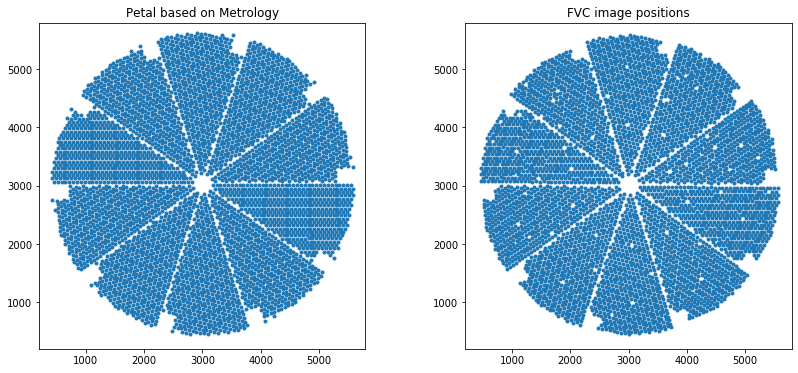

In [30]:
# Try rough alignment (using best-fit params found)
lim1 = 200
lim2 = 5800
scale = 6.31485025
x0 = 3000.3600823
y0 = 3038.49451303
fig, axarr = plt.subplots(1, 2, figsize=(14,6))
axarr[0].plot(-1.*scale*data['obs_x']+x0, scale*data['obs_y']+y0, '.')
axarr[0].set_xlim(lim1, lim2)
axarr[0].set_ylim(lim1, lim2)
axarr[0].set_title("Petal based on Metrology")
posdata = ascii.read(PC00[0])
axarr[1].plot(posdata['col1'], posdata['col2'], '.')
axarr[1].set_xlim(lim1, lim2)
axarr[1].set_ylim(lim1, lim2)
axarr[1].set_title("FVC image positions")
axarr[0].set_aspect('equal')
axarr[1].set_aspect('equal')

In [71]:
# Metrology data: (only use positioner locations if fiducials not on)
xmet = data['obs_x'][posmask]
ymet = data['obs_y'][posmask]

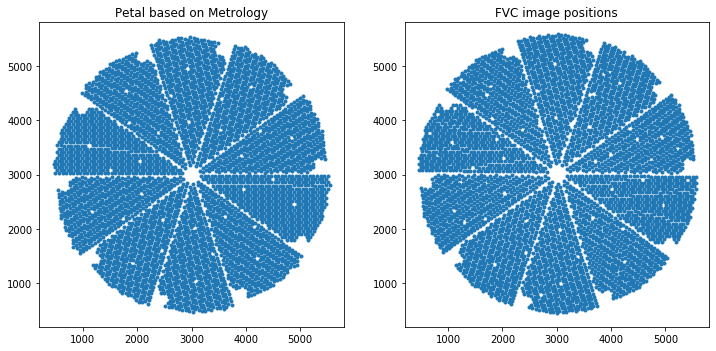

In [72]:
# Test postrans()
params = [6.2, 3000, 3000]
lim1 = 200
lim2 = 5800
xmet_fvc, ymet_fvc = postrans(-1.*xmet, ymet, params)
fig, axarr = plt.subplots(1, 2, figsize=(12,6))
axarr[0].plot(xmet_fvc, ymet_fvc, '.')
axarr[0].set_xlim(lim1, lim2)
axarr[0].set_ylim(lim1, lim2)
axarr[0].set_title("Petal based on Metrology")
posdata = ascii.read(PC00[0])
axarr[1].plot(posdata['col1'], posdata['col2'], '.')
axarr[1].set_xlim(lim1, lim2)
axarr[1].set_ylim(lim1, lim2)
axarr[1].set_title("FVC image positions")
axarr[0].set_aspect('equal')
axarr[1].set_aspect('equal')

In [73]:
# FVC data: (use PC00[0] as it was obtained before any moves)
posdata = ascii.read(PC00[0]) 
xfvc = posdata['col1']
yfvc = posdata['col2']

In [74]:
def optfunc(params):
    '''
    Function to optimize for match between coordinate systems
    params = [rot, x0, y0]
    Note this does not require unique matches, but this isn't the limiting factor
    '''
    Nsample = 10 # Only optimize based on every Nsample positioner (speed up)
    dmin = 30 # Do not penalize if off by less than dmin pix (probably should adjust this)
    # Transform metrology data to FVC coordinates
    xmet_fvc, ymet_fvc = postrans(-1*xmet, ymet, params)
    dist = np.zeros(len(xfvc))
    for i in np.arange(0, len(xfvc), Nsample): # loop through measured spots
        dist[i] = max(np.sqrt(np.power(xmet_fvc-xfvc[i], 2) + np.power(ymet_fvc-yfvc[i], 2)).min(), dmin)
    return np.sum(dist)

In [75]:
# With Nsamp = 10
params = [6.2, 3000, 3000]
res = minimize(optfunc, params, method='Nelder-Mead', tol=.1, options={'maxiter': 10})
print(res)

 final_simplex: (array([[   6.31485025, 3000.3600823 , 3038.49451303],
       [   6.30014551, 2993.99648491, 3009.08850594],
       [   6.51      , 3000.        , 3000.        ],
       [   6.37602281, 2963.61882716, 3016.03652263]]), array([15395.47565663, 15541.96001953, 15551.33572457, 15651.62314674]))
           fun: 15395.47565663336
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 19
           nit: 10
        status: 2
       success: False
             x: array([   6.31485025, 3000.3600823 , 3038.49451303])


In [76]:
# Best output: params = [6.31485025, 3000.3600823, 3038.49451303]
params = res['x']
xmet_fvc_out, ymet_fvc_out = postrans(-1.*xmet, ymet, params)

### Overplot of FVC positions and transformed petal metrology

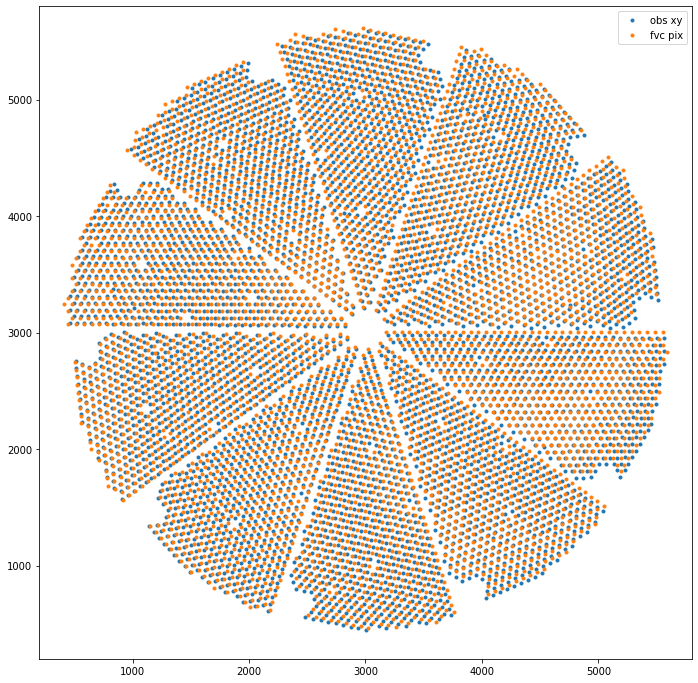

In [77]:
# Overplot FVC coordinates and transformed metrology
# (clearly it would be better to compute separate offsets for each petal)
lim1 = 200
lim2 = 5800
fig, ax = plt.subplots(1, 1, figsize=(14,12))
ax.plot(xfvc, yfvc, '.', label="obs xy")
ax.plot(xmet_fvc_out, ymet_fvc_out, '.', label="fvc pix")
ax.set_xlim(lim1, lim2)
ax.set_ylim(lim1, lim2)
ax.legend()
ax.set_aspect('equal')
fig.savefig('spots.pdf')

### Routines to separate FVC measurements into petals

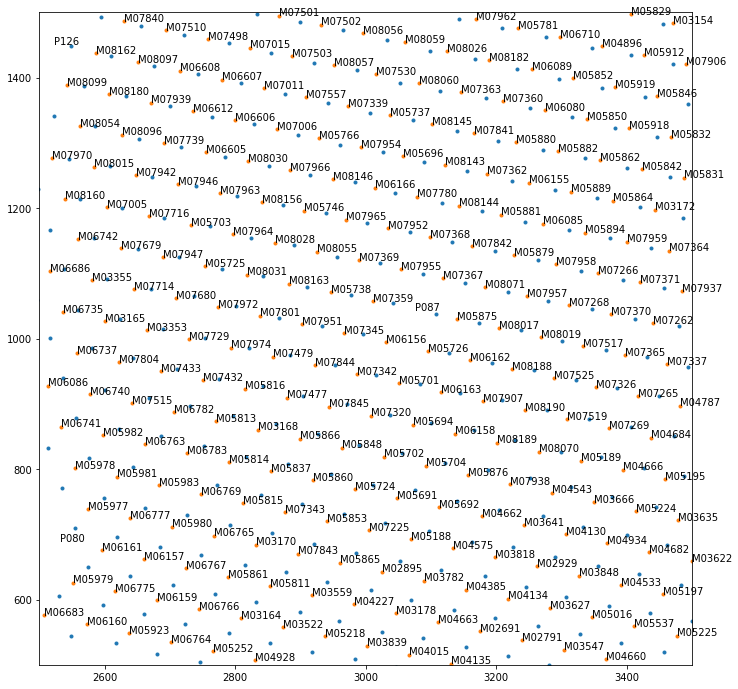

In [24]:
# Recompute transformed metrology with the fiducial positions too
xmet = data['obs_x']
ymet = data['obs_y']
xmet_fvc_all, ymet_fvc_all = postrans(-1.*data['obs_x'], data['obs_y'], params)# Zoom in, add labels
pc00mask = MakePetalMask(xmet_fvc_all, ymet_fvc_all, 0)
xlim1 = 2500
xlim2 = 3500
ylim1 = 500
ylim2 = 1500
plotmask = xmet_fvc_all > xlim1
plotmask = plotmask & (xmet_fvc_all < xlim2)
plotmask = plotmask & (ymet_fvc_all > ylim1)
plotmask = plotmask & (ymet_fvc_all < ylim2)
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
ax.plot(xfvc, yfvc, '.', label="obs xy")
ax.plot(xmet_fvc_out[plotmask], ymet_fvc_out[plotmask], '.', label="fvc pix")

for i in range(len(data.index)):
    if pc00mask[i] and plotmask[i]:
        #ax.annotate( data.index[i], (xmet_fvc_all[i], ymet_fvc_all[i]) )
        ax.text(xmet_fvc_all[i], ymet_fvc_all[i], data.index[i])

ax.set_xlim(xlim1, xlim2)
ax.set_ylim(ylim1, ylim2)
ax.set_aspect('equal')

### Identify the bad moves
Used a criterion of < 3 pixels to identify a bad move

In [25]:
# Get the data for bad moves for a petal:
def getbadmoves(PC, petnum, verbose=False):
    '''
    Returns a pair of boolean arrays with True for bad phi and 
    bad theta moves. Also returns float arrays with the 
    distance to the nearest point in the subsequent file
    '''
    badlim = 3 # less than this is flagged as a bad move
    
    print("PC = {0}, petnum = {1}".format(PC, petnum))
    petal = PC
    posdata1 = ascii.read(petal[0]) # prior to first move of the petal
    petmask1 = MakePetalMask(posdata1['col1'], posdata1['col2'], petnum)
    xpos1, ypos1 = posdata1['col1'][petmask1], posdata1['col2'][petmask1]
    posdata2 = ascii.read(petal[1]) # after phi move
    petmask2 = MakePetalMask(posdata2['col1'], posdata2['col2'], petnum)
    xpos2, ypos2 = posdata2['col1'][petmask2], posdata2['col2'][petmask2]
    posdata3 = ascii.read(petal[2]) # after theta move
    petmask3 = MakePetalMask(posdata3['col1'], posdata3['col2'], petnum)
    xpos3, ypos3 = posdata3['col1'][petmask3], posdata3['col2'][petmask3]
    print(len(xpos1), len(xpos2), len(xpos3))

    petmaskfvc = MakePetalMask(xmet_fvc_all.values, ymet_fvc_all.values, petnum)

    # Calculate the distance each one moved: 
    phidist = np.zeros(len(xpos1))
    thetadist = np.zeros(len(xpos2))
    for i in range(len(xpos1)):
        # find nearest point after phi move: (pos1 - pos2)
        phidist[i] = np.sqrt( np.power(xpos1[i] - xpos2, 2) + np.power(ypos1[i] - ypos2, 2) ).min()
    for i in range(len(xpos2)):
        # after theta move: pos2 - pos3
        thetadist[i] = np.sqrt( np.power(xpos2[i] - xpos3, 2) + np.power(ypos2[i] - ypos3, 2) ).min()
    
    # Create masks for the ones that didn't move
    badphi = phidist < badlim
    badtheta = thetadist < badlim

    print("Number of bad phi measurements = ", sum(badphi))
    for badi in range(sum(badphi)):
        indx = np.where(xpos1.data[badphi][badi] == xpos1)[0]
        if verbose: 
            print(badi, indx, xpos1.data[indx], ypos1.data[indx])
        for j in range(len(xpos2)): # Search in xpos2 to find closest to xpos1
            dist = np.sqrt( np.power(xpos1[indx] - xpos2[j], 2) + np.power(ypos1[indx] - ypos2[j], 2))
            if verbose: 
                if dist < 5.:
                    print(xpos1.data[indx], xpos2.data[j], ypos1.data[indx], ypos2.data[j], dist.data)

    print("Number of bad theta measurements = ", sum(badtheta))
    for i in range(sum(badtheta)):
        indx = np.where(xpos2[badtheta][i] == xpos2)[0]
        if verbose: 
            print(i, indx, xpos2.data[indx], ypos2.data[indx])
        for j in range(len(xpos3)): # Search in xpos3 to find closest in xpos2
            dist = np.sqrt( np.power(xpos2[indx] - xpos3[j], 2) + np.power(ypos2[indx] - ypos3[j], 2))
            if verbose: 
                if dist < 5.:
                    print(xpos2.data[indx], ypos2.data[indx], xpos3.data[j], ypos3.data[j], dist.data)
    
    return badphi, badtheta, phidist, thetadist

In [26]:
def plotbadmoves(petnum):
    size = 100
    petal = petlist[petnum]
    posdata1 = ascii.read(petal[0])
    petmask1 = MakePetalMask(posdata1['col1'], posdata1['col2'], petnum)
    xpos1, ypos1 = posdata1['col1'][petmask1], posdata1['col2'][petmask1]
    posdata2 = ascii.read(petal[1])
    petmask2 = MakePetalMask(posdata2['col1'], posdata2['col2'], petnum)
    xpos2, ypos2 = posdata2['col1'][petmask2], posdata2['col2'][petmask2]
    posdata3 = ascii.read(petal[2])
    petmask3 = MakePetalMask(posdata3['col1'], posdata3['col2'], petnum)
    xpos3, ypos3 = posdata3['col1'][petmask3], posdata3['col2'][petmask3]
    petmaskfvc = MakePetalMask(xmet_fvc_all.values, ymet_fvc_all.values, petnum)

    nphi = sum(badphi[petnum])
    ntheta = sum(badtheta[petnum])
    ntot = nphi + ntheta
    fig, axarr = plt.subplots(ntot, 1, figsize=(4, 4*ntot))
    fig.tight_layout()
    print(axarr.shape)
    # First loop over bad phis
    for i in range(nphi):
        indx = np.where(xpos1[badphi[petnum]][i] == xpos1)[0]  # index of position for a bad positioner
        xlim1 = xpos1[badphi[petnum]][i] - size
        xlim2 = xpos1[badphi[petnum]][i] + size
        ylim1 = ypos1[badphi[petnum]][i] - size
        ylim2 = ypos1[badphi[petnum]][i] + size
        axarr[i].plot(xpos1[indx], ypos1[indx], 'bo', ms=5)
        label = "Phi Motion = {0}".format(phidist[petnum][indx])
        axarr[i].set_title(label)

        for j in range(len(data.index)):
            if (xlim1 < xmet_fvc_all.values[j] < xlim2) and (ylim1 < ymet_fvc_all.values[j] < ylim2):
                axarr[i].text(xmet_fvc_all.values[j], ymet_fvc_all.values[j], data.index[j], ha='center', va='center')

        axarr[i].plot(xpos1, ypos1, 'k.', ms=3)
        axarr[i].plot(xpos2, ypos2, 'k.', ms=3)
        axarr[i].plot(xpos3, ypos3, 'k.', ms=3)
  
        axarr[i].set_xlim(xlim1, xlim2)
        axarr[i].set_ylim(ylim1, ylim2)
        #print(indx, xpos1.data[indx], ypos1.data[indx])
    
    # Now loop over bad thetas
    for k in range(nphi, ntot):
        i = k - nphi
        indx = np.where(xpos2[badtheta[petnum]][i] == xpos2)[0]
        xlim1 = xpos2[badtheta[petnum]][i] - size
        xlim2 = xpos2[badtheta[petnum]][i] + size
        ylim1 = ypos2[badtheta[petnum]][i] - size
        ylim2 = ypos2[badtheta[petnum]][i] + size
        # print(i, indx, xpos2.data[indx], ypos2.data[indx], sum(badtheta))
        axarr[k].plot(xpos2[indx], ypos2[indx], 'bo', ms=5)
        label = "Theta Motion = {0}".format(thetadist[petnum][indx])
        axarr[k].set_title(label)

        for j in range(len(data.index)):
            if (xlim1 < xmet_fvc_all.values[j] < xlim2) and (ylim1 < ymet_fvc_all.values[j] < ylim2):
                axarr[k].text(xmet_fvc_all.values[j], ymet_fvc_all.values[j], data.index[j], ha='center', va='center')

        axarr[k].plot(xpos1, ypos1, 'k.', ms=3)
        axarr[k].plot(xpos2, ypos2, 'k.', ms=3)
        axarr[k].plot(xpos3, ypos3, 'k.', ms=3)

        axarr[k].set_xlim(xlim1, xlim2)
        axarr[k].set_ylim(ylim1, ylim2)

### Compute data on the bad moves for all petals

In [27]:
badphi0, badtheta0, phidist0, thetadist0 = getbadmoves(PC00, 0)
badphi1, badtheta1, phidist1, thetadist1 = getbadmoves(PC01, 1)
badphi2, badtheta2, phidist2, thetadist2 = getbadmoves(PC02, 2)
badphi3, badtheta3, phidist3, thetadist3 = getbadmoves(PC03, 3)
badphi4, badtheta4, phidist4, thetadist4 = getbadmoves(PC04, 4)
badphi5, badtheta5, phidist5, thetadist5 = getbadmoves(PC05, 5)
badphi6, badtheta6, phidist6, thetadist6 = getbadmoves(PC06, 6)
badphi7, badtheta7, phidist7, thetadist7 = getbadmoves(PC07, 7)
badphi8, badtheta8, phidist8, thetadist8 = getbadmoves(PC08, 8)
badphi9, badtheta9, phidist9, thetadist9 = getbadmoves(PC09, 9)

PC = ['fvc.20191003232306.pos', 'fvc.20191003233356.pos', 'fvc.20191003234547.pos'], petnum = 0
499 499 499
Number of bad phi measurements =  5
Number of bad theta measurements =  9
PC = ['fvc.20191003234904.pos', 'fvc.20191004000051.pos', 'fvc.20191004001051.pos'], petnum = 1
500 500 500
Number of bad phi measurements =  1
Number of bad theta measurements =  29
PC = ['fvc.20191004170751.pos', 'fvc.20191004190200.pos', 'fvc.20191004191322.pos'], petnum = 2
503 548 548
Number of bad phi measurements =  8
Number of bad theta measurements =  76
PC = ['fvc.20191003213313.pos', 'fvc.20191003214640.pos', 'fvc.20191003222441.pos'], petnum = 3
496 496 496
Number of bad phi measurements =  75
Number of bad theta measurements =  16
PC = ['fvc.20191003222441.pos', 'fvc.20191004190200.pos', 'fvc.20191007152624.pos'], petnum = 4
496 544 496
Number of bad phi measurements =  4
Number of bad theta measurements =  13
PC = ['fvc.20191007152624.pos', 'fvc.20191007153833.pos', 'fvc.20191007162144.pos'], 

In [29]:
badphi = [badphi0, badphi1, badphi2, badphi3, badphi4, badphi5, badphi6, badphi7, badphi8, badphi9]
badphi = [badphi0, badphi1, badphi2, badphi3, badphi4, badphi5, badphi6, badphi7, badphi8, badphi9]
thetadist = [thetadist0, thetadist1, thetadist2, thetadist3, thetadist4, thetadist5, thetadist6, thetadist7, thetadist8, thetadist9]
phidist = [phidist0, phidist1, phidist2, phidist3, phidist4, phidist5, phidist6, phidist7, phidist8, phidist9]

In [46]:
xmet_fvc_all[petmaskfvc].shape

(516,)

In [37]:
petnum = 0
petmaskfvc = MakePetalMask(xmet_fvc_all, ymet_fvc_all, petnum)
xmet_fvc_all[petmaskfvc]

### Plot a histogram of the distances each positioner moves

<IPython.core.display.Javascript object>


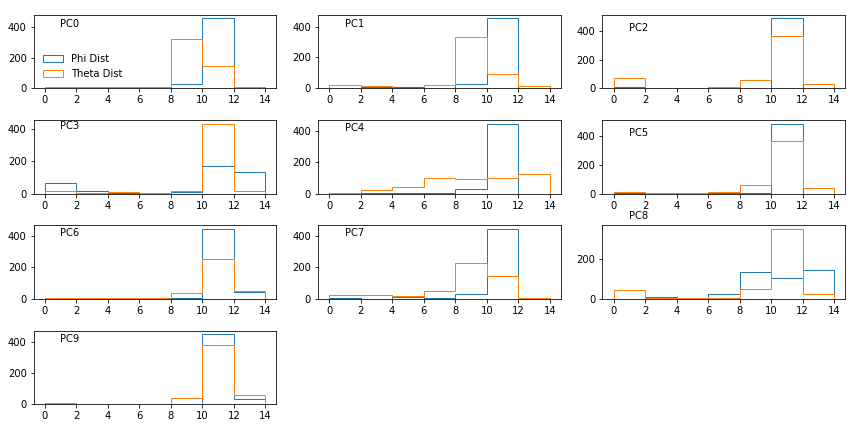

(0.0, 1.0, 0.0, 1.0)

In [151]:
bins = np.arange(0, 16, 2)
fig, axarr = plt.subplots(4, 3, figsize=(12, 6), frameon=False)
fig.tight_layout()
logbool = False
axarr[0][0].hist(phidist0, bins, histtype='step', log=logbool, label="Phi Dist")
axarr[0][0].hist(thetadist0, bins, histtype='step', log=logbool, label="Theta Dist")
axarr[0][0].legend(loc="lower left", frameon=False)
axarr[0][0].text(1, 400, "PC0")
axarr[0][1].hist(phidist1, bins, histtype='step', log=logbool)
axarr[0][1].hist(thetadist1, bins, histtype='step', log=logbool)
axarr[0][1].text(1, 400, "PC1")
axarr[0][2].hist(phidist2, bins, histtype='step', log=logbool)
axarr[0][2].hist(thetadist2, bins, histtype='step', log=logbool)
axarr[0][2].text(1, 400, "PC2")
axarr[1][0].hist(phidist3, bins, histtype='step', log=logbool)
axarr[1][0].hist(thetadist3, bins, histtype='step', log=logbool)
axarr[1][0].text(1, 400, "PC3")
axarr[1][1].hist(phidist4, bins, histtype='step', log=logbool)
axarr[1][1].hist(thetadist4, bins, histtype='step', log=logbool)
axarr[1][1].text(1, 400, "PC4")
axarr[1][2].hist(phidist5, bins, histtype='step', log=logbool)
axarr[1][2].hist(thetadist5, bins, histtype='step', log=logbool)
axarr[1][2].text(1, 400, "PC5")
axarr[2][0].hist(phidist6, bins, histtype='step', log=logbool)
axarr[2][0].hist(thetadist6, bins, histtype='step', log=logbool)
axarr[2][0].text(1, 400, "PC6")
axarr[2][1].hist(phidist7, bins, histtype='step', log=logbool)
axarr[2][1].hist(thetadist7, bins, histtype='step', log=logbool)
axarr[2][1].text(1, 400, "PC7")
axarr[2][2].hist(phidist8, bins, histtype='step', log=logbool)
axarr[2][2].hist(thetadist8, bins, histtype='step', log=logbool)
axarr[2][2].text(1, 400, "PC8")
axarr[3][0].hist(phidist9, bins, histtype='step', log=logbool)
axarr[3][0].hist(thetadist9, bins, histtype='step', log=logbool)
axarr[3][0].text(1, 400, "PC9")
axarr[3][1].axis('off')
axarr[3][2].axis('off')

### Maps of Bad Phi and Bad Theta Moves
Note bad CANBUS on PC03 affected phi move, but not theta move

<IPython.core.display.Javascript object>


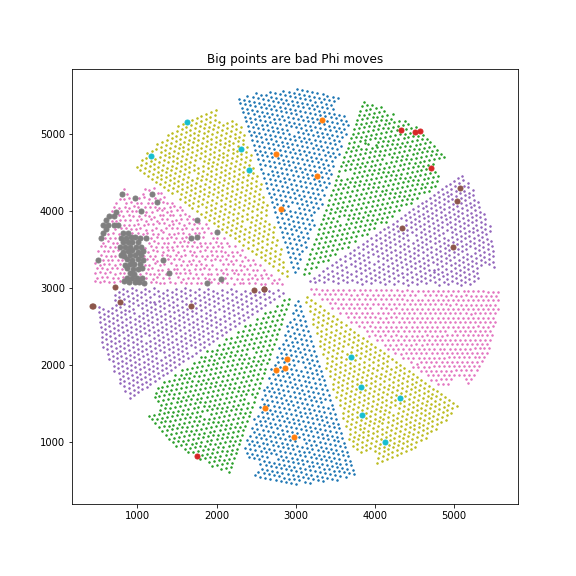

Text(0.5, 1.0, 'Big points are bad Phi moves')

In [153]:
# Bad Phi Map
plt.figure(figsize=(8, 8))
fig.tight_layout()
badphi = [badphi0, badphi1, badphi2, badphi3, badphi4, badphi5, badphi6, badphi7, badphi8, badphi9]
for i in petal_locs:
    pet = petlist[i]
    pos1 = ascii.read(pet[0])
    petmask = MakePetalMask(pos1['col1'], pos1['col2'], i)
    plt.plot(pos1['col1'][petmask], pos1['col2'][petmask], '.', ms=3)
    plt.plot(pos1['col1'][petmask][badphi[i]], pos1['col2'][petmask][badphi[i]], '.', ms=10)
plt.title("Big points are bad Phi moves")

<IPython.core.display.Javascript object>


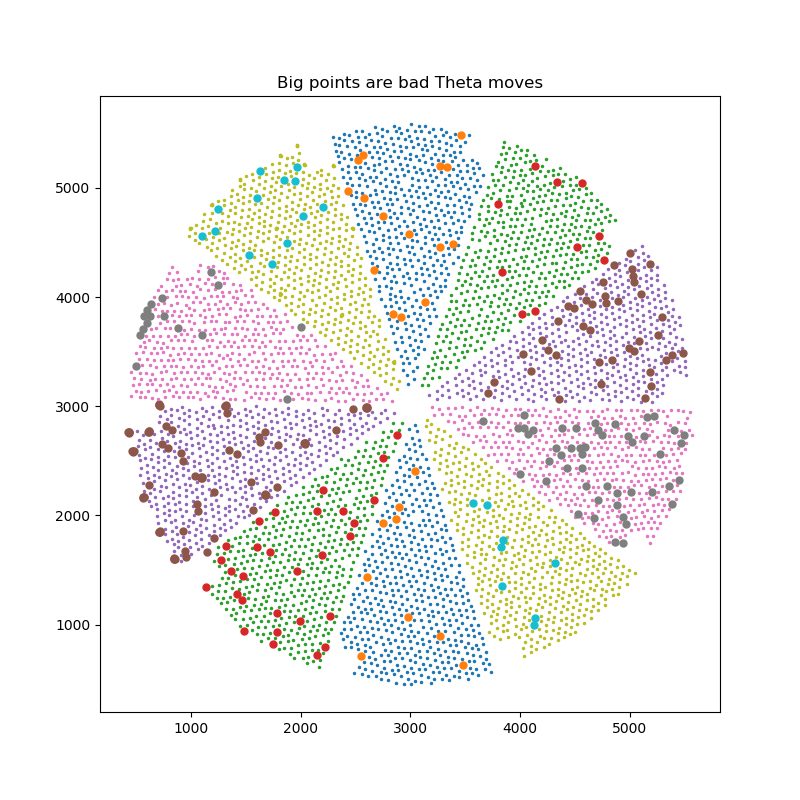

Text(0.5, 1.0, 'Big points are bad Theta moves')

In [141]:
# Bad Theta Map
plt.figure(figsize=(8, 8))
fig.tight_layout()
petlist = [PC00, PC01, PC02, PC03, PC04, PC05, PC06, PC07, PC08, PC09]
badphi = [badphi0, badphi1, badphi2, badphi3, badphi4, badphi5, badphi6, badphi7, badphi8, badphi9]
badtheta = [badtheta0, badtheta1, badtheta2, badtheta3, badtheta4, badtheta5, badtheta6, badtheta7, badtheta8, badtheta9]
for i in petal_locs:
    pet = petlist[i]
    pos2 = ascii.read(pet[1])
    petmask = MakePetalMask(pos2['col1'], pos2['col2'], i)
    plt.plot(pos2['col1'][petmask], pos2['col2'][petmask], '.', ms=3)
    plt.plot(pos2['col1'][petmask][badtheta[i]], pos2['col2'][petmask][badtheta[i]], '.', ms=10)
    
plt.title("Big points are bad Theta moves")

### Zoom in to inspect individual cases in a petal

<IPython.core.display.Javascript object>


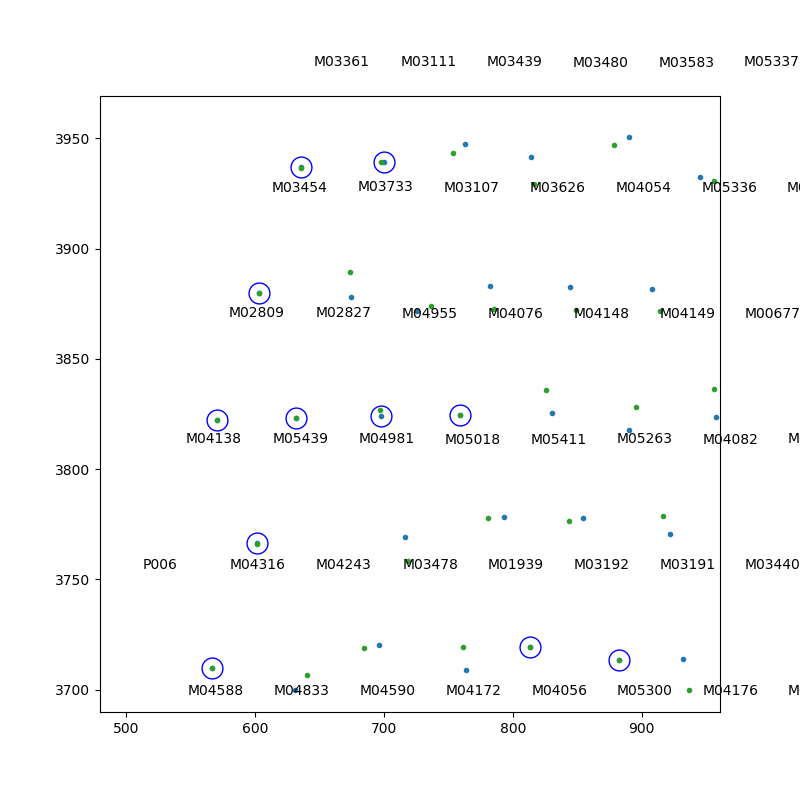

In [142]:
# See which positioners have moved in theta (display first and second)
petnum = 3
plt.figure(figsize=(8, 8))
posdata = ascii.read(petlist[petnum][0])
petmask = MakePetalMask(posdata['col1'], posdata['col2'], petnum)
plt.plot(posdata['col1'][petmask], posdata['col2'][petmask], '.')
plt.errorbar(posdata['col1'][petmask][badphi[petnum]], posdata['col2'][petmask][badphi[petnum]], marker='o', ms=15, mfc='none', mec='blue',ls='none' )
posdata = ascii.read(petlist[petnum][1])
petmask = MakePetalMask(posdata['col1'], posdata['col2'], petnum)
plt.plot(posdata['col1'][petmask], posdata['col2'][petmask], '.')

fvcmask = MakePetalMask(xmet_fvc_all, ymet_fvc_all, petnum)
for i in range(len(data.index)):
    if fvcmask[i]:
        plt.text(xmet_fvc_all[i], ymet_fvc_all[i], data.index[i], fontsize=10)

### Plots of individual, suspect positioners

<IPython.core.display.Javascript object>


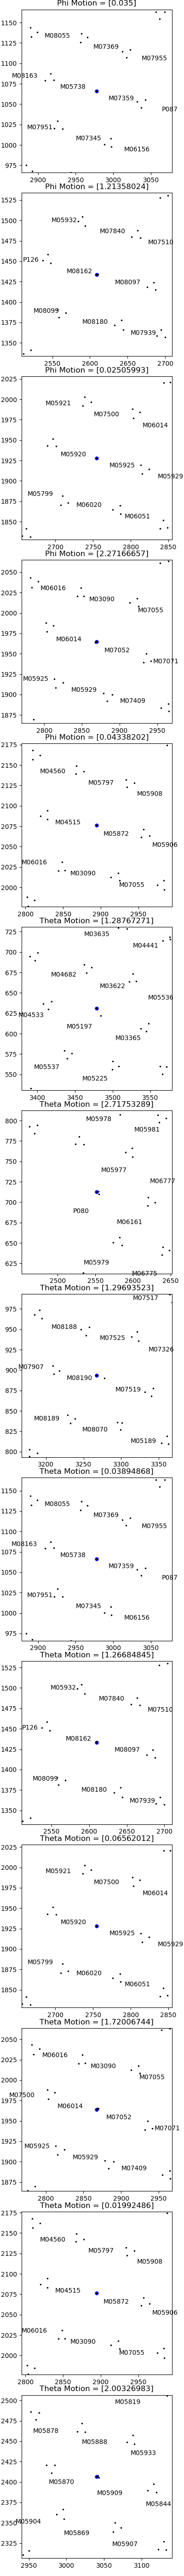

(14,)


In [133]:
#plotbadmoves(badphi0, badtheta0, PC00, 0, phidist0, thetadist0)
plotbadmoves(0)

<IPython.core.display.Javascript object>


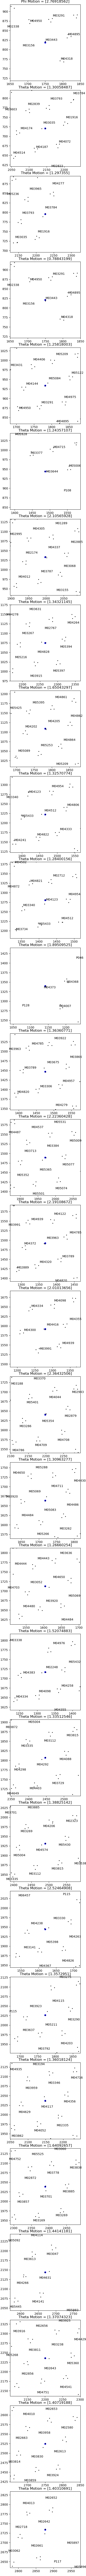

(30,)


In [134]:
plotbadmoves(1)

<IPython.core.display.Javascript object>


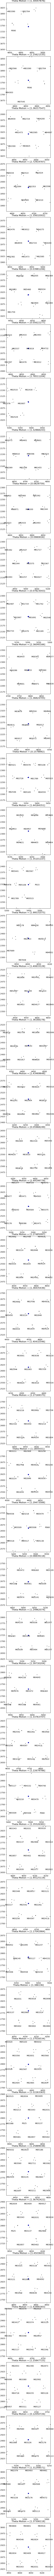

(48,)


In [137]:
plotbadmoves(8)

<IPython.core.display.Javascript object>


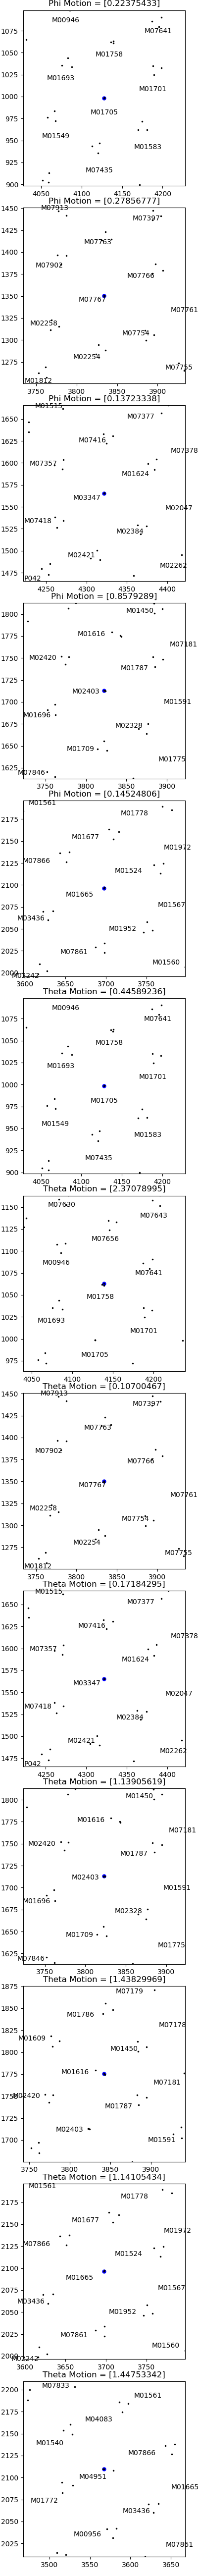

(13,)


In [138]:
plotbadmoves(9)